In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from pandas import DataFrame, concat
from pandas import DataFrame
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import itertools
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from joblib import parallel_backend
from sklearn.model_selection import GridSearchCV
import sys
import os
from tensorflow import keras

# Harmonize Datasets

In [89]:
df_triage = pd.read_csv('../triage/data/triage_initial_preprocessed.csv', sep=";", decimal=",")
df_harvard = pd.read_csv('../harvard/data/harvard_initial_preprocessed.csv', sep=";", decimal=",")

## Select Relevant Features

In [90]:
# TODO include medications and help with daily activities

relevant_vars_triage = [
    '2+ Exa. last year', # bclinpt22
    'Age', # dem02
    'Asthma', # bclinpt14
    'BMI', # bmi - from height (bclinra01)  and weight (bclinra02)
    'Congestive Heart Failure', # bclinpt07
    'Coronary Artery Disease', # blcinpt06
    'Cough', # bclinpt30
    'Current Temperature', # could turn this into fever (bclinpt34)
    # 'Daily Controller Inhaler', # from all the medications
    'Diabetes', # bclinpt15
    'Exacerbation', # fclinra08
    'FEV1', # bclinra202
    'FEV1 %', # bclinra202c
    'Gender', # dem03
    'Gold', # bclinra11
    'Height', # bclinra01
    # 'Help Daily Activities', # An14
    'Hospitalized last year', # bclinpt24
    'Hypertension', # bclinpt04
    'ICU last year', # bclinpt26
    'Kidney Disease', # bclinpt11
    'Lives Alone', # socio06
    'MMRC', # mmrc
    'Night Symptoms', # psqidistb (sleep disturbance score)
    # 'Oxygen Therapy', # oxygen therapy
    # 'Pill Exa', # possibly from all the medications
    # 'Presc Inhaler', # possibly from all the medications
    # 'Rescue Inhaler', # possibly from all the medications
    # 'Rescue inhaler or Nebulizer', # possibly from all the medications
    'Shortness of Breath', #bclinpt28
    'Smoker', # all participants are smokers
    'Sputum', # bclinpt32
    'Weight', # bclinra02
    'Wheeze', # bclinpt38
]

df_triage_selected = df_triage[relevant_vars_triage]

relevant_vars_harvard = [
    'bclinpt22',
    'dem02',
    'bclinpt14',
    'bclinra01',
    'bclinra02',
    'bclinpt07',
    'bclinpt06',
    'bclinpt30',
    'bclinpt15',
    'fclinra08',
    'bclinra202',
    'bclinra202c_2',
    'bclinra202c_5',
    'dem03',
    'bclinra11',
    # 'An14_Bank',
    'bclinpt24',
    'bclinpt04',
    'bclinpt26',
    'bclinpt11',
    'mmrc',
    # 'Oxygen_ra',
    'psqidistb',
    'bclinpt28',
    'bclinpt32',
    'bclinpt38',
    # 'Advair_ra',
    # 'Albuterol_ra',
    # 'Beclomethasone_ra',
    # 'Budesonide_ra',
    # 'Combivent_ra',
    # 'Flucticasone_ra',
    # 'Formoterol_ra',
    # 'Ipratropium_ra',
    # 'Levaquin_ra',
    # 'Mometasone_ra',
    # 'Serevent_ra',
    # 'Singulair_ra',
    # 'Tiotropium_ra',
    # 'Xopenex_ra',
    'socio06',
    'bclinpt34',
]

df_harvard_selected = df_harvard[relevant_vars_harvard]

## Simple harmonization using formatting and binarization


In [109]:
df_triage_simple_harmo = df_triage_selected.copy()
df_harvard_simple_harmo = df_harvard_selected.copy()

## TRIAGE
# fever == 1 if (temp > 38°C)
df_triage_simple_harmo['Fever'] = 0
df_triage_simple_harmo.loc[df_triage_simple_harmo['Current Temperature'] > 38, 'Fever'] = 1
df_triage_simple_harmo.drop(columns=['Current Temperature'], inplace=True)


# TODO something is still off with all these binary variables

## HARVARD
# print bclinpt22 sorted values counts
print(df_harvard_simple_harmo['bclinpt22'].value_counts())
print(df_harvard_simple_harmo['bclinpt24'].value_counts())
print(df_harvard_simple_harmo['bclinpt26'].value_counts())
print(df_harvard_simple_harmo['socio06'].value_counts())


# turn bclinpt22 into 2+ exa last year (2+ exa last year = bclinpt22 >= 3)
df_harvard_simple_harmo['2+ Exa. last year'] = 0
df_harvard_simple_harmo.loc[df_harvard_simple_harmo['bclinpt22'] >= 3, '2+ Exa. last year'] = 1
df_harvard_simple_harmo.drop(columns=['bclinpt22'], inplace=True)

# hospitalized last year
df_harvard_simple_harmo['Hospitalized last year'] = 0
df_harvard_simple_harmo.loc[df_harvard_simple_harmo['bclinpt24'] >= 2, 'Hospitalized last year'] = 1
df_harvard_simple_harmo.drop(columns=['bclinpt24'], inplace=True)
# icu last year
df_harvard_simple_harmo['ICU last year'] = 0
df_harvard_simple_harmo.loc[df_harvard_simple_harmo['bclinpt26'] >= 2, 'ICU last year'] = 1
df_harvard_simple_harmo.drop(columns=['bclinpt26'], inplace=True)

# TODO consider getting rid of smoker variable
df_harvard_simple_harmo['Smoker'] = 1

# lives alone (socio06 is Never Married (1),Separated (4), Divorced (5) or Widowed(6))
df_harvard_simple_harmo['Lives Alone'] = 0
df_harvard_simple_harmo.loc[df_harvard_simple_harmo['socio06'].isin([1, 4, 5, 6]), 'Lives Alone'] = 1
df_harvard_simple_harmo.drop(columns=['socio06'], inplace=True)

# print value counts after
print(df_harvard_simple_harmo['2+ Exa. last year'].value_counts())
print(df_harvard_simple_harmo['Hospitalized last year'].value_counts())
print(df_harvard_simple_harmo['ICU last year'].value_counts())
print(df_harvard_simple_harmo['Lives Alone'].value_counts())

# TODO % FEV1 b and % FEV1 and how they are created


1.0    65
3.0    48
2.0    31
4.0     5
5.0     1
Name: bclinpt22, dtype: int64
1.0    87
2.0    36
3.0    26
Name: bclinpt24, dtype: int64
1.0    98
3.0    28
2.0    22
4.0     1
Name: bclinpt26, dtype: int64
2.0    63
5.0    35
6.0    26
1.0    10
3.0     8
4.0     7
Name: socio06, dtype: int64
0    96
1    54
Name: 2+ Exa. last year, dtype: int64
0    88
1    62
Name: Hospitalized last year, dtype: int64
0    99
1    51
Name: ICU last year, dtype: int64
1    78
0    72
Name: Lives Alone, dtype: int64


## Medications

In [92]:
# Prescribed inhaler: Advair, 


# Rescue inhaler

# Daily Controller inhaler (Azithromycin, Roflikulast): Advair

# Pill Exa

# Rescue inhaler or nebulizer: Advair

## Renaming

In [110]:
harvard_rename_dict = {
    'dem02': 'Age',
    'bclinpt14': 'Asthma',
    'bclinra01': 'Height',
    'bclinra02': 'Weight',
    'bclinpt07': 'Congestive Heart Failure',
    'bclinpt06': 'Coronary Artery Disease',
    'bclinpt30': 'Cough',
    'bclinpt15': 'Diabetes',
    'fclinra08': 'Exacerbation',
    'bclinra202': 'FEV1',
    'bclinra202c_2': 'FEV1 % a',
    'bclinra202c_5': 'FEV1 % b',
    'dem03': 'Gender',
    'bclinra11': 'Gold',
    'bclinpt04': 'Hypertension',
    'bclinpt11': 'Kidney Disease',
    'mmrc': 'MMRC',
    'Oxygen_ra': 'Oxygen',
    'psqidistb': 'PSQI Disturbance',
    'bclinpt28': 'Shortness of Breath',
    'bclinpt32': 'Sputum',
    'bclinpt38': 'Wheezing',
    'bclinpt34': 'Fever',
    # 'Advair_ra': None,
    # 'Albuterol_ra': None,
    # 'Beclomethasone_ra': None,
    # 'Budesonide_ra': None,
    # 'Combivent_ra': None,
    # 'Flucticasone_ra': None,
    # 'Formoterol_ra': None,
    # 'Ipratropium_ra': None,
    # 'Levaquin_ra': None,
    # 'Mometasone_ra': None,
    # 'Serevent_ra': None,
    # 'Singulair_ra': None,
    # 'Tiotropium_ra': None,
    # 'Xopenex_ra': None,
}

df_harvard_renamed = df_harvard_simple_harmo.rename(columns=harvard_rename_dict)
    

## Harmonization using distributions

Some variables have a different question pattern or are entirely different we thus need to look at the distributions of each for the exacerbation and non-exacerbation outcome to develop a harmonization strategy

In [111]:
import seaborn as sns

# create a figure with subplots depending on the number of variables using sqrt
height,width = 5,6
fig, axs = plt.subplots(height, width, figsize=(100, 100))
positives = df_harvard_renamed[df_harvard_renamed['Exacerbation'] == 1]
negatives = df_harvard_renamed[df_harvard_renamed['Exacerbation'] == 0]
# plot the histogram of each variable
row, col = 0, 0
for var in df_harvard_renamed.columns:
    # if we are at the end of the row, move to the next row
    if col == width:
        row += 1
        col = 0
    # create 
    bins = len(df_harvard_renamed[var].unique())
    sns.histplot(positives[var], ax=axs[row, col], color='orange', label='Exacerbator', alpha=0.5, kde=True, bins=bins)
    sns.histplot(negatives[var], ax=axs[row, col], color='blue', label='Non-exacerbator', alpha=0.5, kde=True, bins=bins)
  
    # set title
    axs[row, col].set_title(var)
    # add legend
    axs[row, col].legend(loc='upper right')
    # move to the next column
    col += 1

In [97]:
# now the same for triage

height,width = 5,6
fig, axs = plt.subplots(height, width, figsize=(100, 100))
positives = df_triage_simple_harmo[df_triage_simple_harmo['Exacerbation'] == 1]
negatives = df_triage_simple_harmo[df_triage_simple_harmo['Exacerbation'] == 0]
# plot the histogram of each variable
row, col = 0, 0
for var in df_triage_simple_harmo.columns:
    # if we are at the end of the row, move to the next row
    if col == width:
        row += 1
        col = 0
    # create 
    bins = len(df_triage_simple_harmo[var].unique())
    sns.histplot(positives[var], ax=axs[row, col], color='orange', label='Exacerbator', alpha=0.5, kde=True, bins=bins)
    sns.histplot(negatives[var], ax=axs[row, col], color='blue', label='Non-exacerbator', alpha=0.5, kde=True, bins=bins)
  
    # set title
    axs[row, col].set_title(var)
    # add legend
    axs[row, col].legend(loc='upper right')
    # move to the next column
    col += 1

In [102]:
# Now we adapt the wheeze, cough, sputum and shortness of breath questions to see if the distribution becomes more similar
df_triage_dist_harmo = df_triage_simple_harmo.copy()

old_wheeze = df_triage_dist_harmo['Wheeze']
# if wheeze is 3 set it to 1 otherwise set it to 0
df_triage_dist_harmo['Wheeze'] = np.where(old_wheeze == 2, 1, 0)

old_cough = df_triage_dist_harmo['Cough']
# if cough is 3 set it to 1 otherwise set it to 0
df_triage_dist_harmo['Cough'] = np.where(old_cough == 2, 1, 0)

old_sputum = df_triage_dist_harmo['Sputum']
# if sputum is 3 set it to 1 otherwise set it to 0
df_triage_dist_harmo['Sputum'] = np.where(old_sputum == 2, 1, 0)

old_shortness_of_breath = df_triage_dist_harmo['Shortness of Breath']
# if shortness_of_breath is 3 set it to 1 otherwise set it to 0
df_triage_dist_harmo['Shortness of Breath'] = np.where(old_shortness_of_breath == 2, 1, 0)

# Now we can see the distribution of the triage questions
height,width = 5,6
fig, axs = plt.subplots(height, width, figsize=(100, 100))
positives = df_triage_dist_harmo[df_triage_dist_harmo['Exacerbation'] == 1]
negatives = df_triage_dist_harmo[df_triage_dist_harmo['Exacerbation'] == 0]
# plot the histogram of each variable
row, col = 0, 0
for var in df_triage_dist_harmo.columns:
    # if we are at the end of the row, move to the next row
    if col == width:
        row += 1
        col = 0
    # create 
    bins = len(df_triage_dist_harmo[var].unique())
    sns.histplot(positives[var], ax=axs[row, col], color='orange', label='Exacerbator', alpha=0.5, kde=True, bins=bins)
    sns.histplot(negatives[var], ax=axs[row, col], color='blue', label='Non-exacerbator', alpha=0.5, kde=True, bins=bins)
  
    # set title
    axs[row, col].set_title(var)
    # add legend
    axs[row, col].legend(loc='upper right')
    # move to the next column
    col += 1

 2    1208
 1     627
 0     568
-1       1
Name: Wheeze, dtype: int64
 1    1249
 2     608
 0     546
-1       1
Name: Cough, dtype: int64
 3    1080
 1     461
 0     446
 2     416
-1       1
Name: Sputum, dtype: int64
 1    1271
 2     576
 0     556
-1       1
Name: Shortness of Breath, dtype: int64


# Preprocess Harvard

In [96]:
target = 'fclinra08'

# missing: gold stage, cough, sputum, wheeze, baseline fev1, baseline fev1% predicted, symptoms wake you up at night, 2 ore more exacerbations in the last year, asthma, needs help with daily activities, chronic kidney disease, icu last year, hospitalized last year, smoker, pill for exa, inhaler
relevant_vars = ['dem02', 'dem03', 'bclinra01', 'bclinra02', 'bclinpt04', 'bclinpt15', 'mmrc', 'bclinpt07', 'bclinpt34',  'bclinpt28',  'login', 'bclinpt19', 'bclinpt08','bclinpt09','bclinpt38', 'bclinpt32','bclinra11','bclinra07','psqi09','sgrq02','sgrq03', 'exact4', 'exact3', 'sgrq05','sgrq09', 'bclinra101', 'bclinra202c_2', 'bclinra202c_5', 'psqi06', 'bclinpt14','SRPSAT49_Bank','bclinpt11' ,'bclinpt26', 'bclinpt24','bclinpt43', 'bclinpt44','bclinpt45','bclinra06','bclinra06_1024','bclinra06_512','bclinra06_256','bclinra06_128','bclinra06_64','bclinra06_32','bclinra06_16','bclinra06_8','bclinra06_4','bclinra06_2','bclinra06_1', 'exact2','bclinpt22', 'bclinpt06', target] # (cancer), 'bclinpt36' fast breathing, 

# load harvard dataset
harvard = pd.read_csv('../harvard/data/dropped_variables.csv', sep=";")
harvard = harvard[relevant_vars]

# change mmrc by starting at 0 instead of 1
harvard['mmrc'] = harvard['mmrc'] - 1

# make female 0 and male = 1
harvard.loc[harvard['dem03'] == 2, 'dem03'] = 0
harvard.loc[harvard['dem03'] == 1, 'dem03'] = 1

# rename columns to common names with exaggerate
harvard = harvard.rename(columns={
    'dem02':'age', 
    'dem03': 'gender', 
    'bclinpt19': 'cancer', 
    'bclinpt04': 'hypertension', 
    'bclinpt15': 'diabetes', 
    'bclinpt07': 'heart_failure', 
    'bclinpt06': 'ischemic_heart_disease',
    target: 'target', 
    'bclinra01': 'height', 
    'bclinra02': 'weight', 
    'bclinpt34': 'fever',  
    'bclinpt08':'myocardial_infarct', 
    'bclinpt09':'stroke', 
    'bclinpt28':'dyspnoea', 
    'bclinpt36': 'fast_breathing', 
    'mmrc': 'mmrc', 
    'bclinpt22': 'prev_exacerb',
    'bclinpt38': 'wheezing',
    'sgrq05': 'wheezing_attacks',
    'sgrq09': 'wheeze_morning', 
    'bclinpt32': 'sputum',
    'sgrq03': 'bring_up_sputum',
    'exact4': 'how_difficult_sputum',
    'exact3': 'how_much_sputum',
    'bclinra11': 'gold',
    'exact2': 'cough_today',
    'psqi09': 'cough_snore',
    'sgrq02': 'cough_four_weeks',
    'sgrq20': 'cough_hurts',
    'sgrq21': 'cough_tired',
    'bclinra101': 'fev1',
    'bclinra202c_2': 'percent_fev1_pred',
    'bclinra202c_5': 'percent_fev1_pred_2',
    'psqi06': 'waking_up_at_night',
    'bclinpt14': 'asthma',
    'bclinpt11': 'chronic_kidney_disease',
    'bclinpt26': 'icu_last_year',
    'bclinpt24': 'hospitalizations_last_year',
    'bclinpt43': 'medication_copd',
    'bclinpt44': 'other_antibiotic',
    'bclinpt45': 'other_medication',
    'bclinra06': 'medication_copd_2',
    'bclinra06_1024': 'other_copd_medication',
    'bclinra06_512': 'qvar',
    'bclinra06_256': 'azmacort',
    'bclinra06_128': 'pulmicort',
    'bclinra06_64': 'flovent',
    'bclinra06_32': 'foradil',
    'bclinra06_16': 'serevent',
    'bclinra06_8': 'spiriva',
    'bclinra06_4': 'combivent',
    'bclinra06_2': 'atrovent',
    'bclinra06_1': 'proventil',
 }) 

# generate the cough variable
harvard['cough'] = 0

# if cought_today is 2,3,4 or 5 set cough to 1
harvard.loc[harvard['cough_today'] > 1, 'cough'] = 1

# TODO check if we should use this variable. Seems like it might be related to snoring only
# if cough_snore is > 1 set cough to 1
# harvard.loc[harvard['cough_snore'] > 1, 'cough'] = 1
# if cough_four_weeks is < 4 set cough to 1
harvard.loc[harvard['cough_four_weeks'] < 4, 'cough'] = 1
# drop cough_today, cough_snore, cough_four_weeks
harvard = harvard.drop(columns=['cough_today', 'cough_snore', 'cough_four_weeks'], axis=1)

# TODO we could use other sputum variables as well
# if 'sputum' is 0 set it to 1 and the other way around
harvard['sputum'] = 1 - harvard['sputum']

# if 'sputum' is na and bring_up_sputum is < 4 set it to 1
harvard.loc[harvard['sputum'].isna() & (harvard['bring_up_sputum'] < 4), 'sputum'] = 1

# drop bring_up_sputum, how_difficult_sputum, how_much_sputum
harvard = harvard.drop(columns=['bring_up_sputum', 'how_difficult_sputum', 'how_much_sputum'], axis=1)

# reconstruct wheezing from sgrq05, bclinpt38, sgrq09
harvard['wheezing'] = 1 - harvard['wheezing']

# if wheezing is na and wheezing_attacks is < 4 set it to 1
harvard.loc[harvard['wheezing'].isna() & (harvard['wheezing_attacks'] < 4), 'wheezing'] = 1
harvard.loc[harvard['wheezing'].isna() & (harvard['wheeze_morning'] == 2 ), 'wheezing'] = 1
harvard = harvard.drop(columns=['wheezing_attacks', 'wheeze_morning'], axis=1)

# calculate 2 or more exacerbations last year variable
harvard['two_exacerbations_last_year'] = harvard['prev_exacerb']
harvard.loc[harvard['two_exacerbations_last_year'] <= 2, 'two_exacerbations_last_year'] = 0
harvard.loc[harvard['two_exacerbations_last_year'] > 2, 'two_exacerbations_last_year'] = 1
harvard = harvard.drop(columns=['prev_exacerb'], axis=1)
# TODO maybe we have to use a different exacerbation definition

# if patient was to the icu at least one time
harvard['icu'] = harvard['icu_last_year']
harvard.loc[harvard['icu'] == 1, 'icu'] = 0
harvard.loc[harvard['icu'] > 1, 'icu'] = 1
harvard = harvard.drop(columns=['icu_last_year'], axis=1)

# reconstruction hospital from bclinpt26 (icu), bclinpt27 (icu), bclinpt24, bclinpt25
harvard['hospitalization'] = harvard['hospitalizations_last_year']
harvard.loc[harvard['hospitalization'] == 1, 'hospitalization'] = 0
harvard.loc[harvard['hospitalization'] > 1, 'hospitalization'] = 1
harvard.loc[harvard['hospitalization'].isna() & (harvard['icu'] == 1), 'hospitalization'] = 1
harvard = harvard.drop(columns=['hospitalizations_last_year'], axis=1)
# don't use daily activities as data is not sufficient

# create smoker variable (everyone)
harvard['smoker'] = 1

# create inhaler variable
harvard['inhaler'] = 0
harvard.loc[(harvard['qvar'] == 1) | (harvard['azmacort'] == 1) | (harvard['flovent'] == 1)| (harvard['foradil'] == 1)| (harvard['serevent'] == 1)| (harvard['spiriva'] == 1)| (harvard['combivent'] == 1)| (harvard['atrovent'] == 1) | (harvard['proventil'] == 1)| (harvard['pulmicort'] == 1), 'inhaler'] = 1
# drop inhaler columns
harvard = harvard.drop(columns=['qvar', 'azmacort', 'flovent', 'foradil', 'serevent', 'spiriva', 'combivent', 'atrovent', 'proventil', 'pulmicort'], axis=1)

# create pill for exa variable
    # bclinpt43 = 2048, 1024, 4096, 
    # bclinpt44 any
harvard['pill_for_exa'] = 0
harvard.loc[(harvard['medication_copd'] == 2048) | (harvard['medication_copd'] == 1024)| (harvard['medication_copd'] == 4096), 'pill_for_exa'] = 1
harvard = harvard.drop(columns=['medication_copd', 'other_antibiotic','other_medication', 'medication_copd_2', 'other_copd_medication' ], axis=1)

# if percent_fev1_pred is na take percent_fev1_pred_2
harvard['percent_fev1_pred'] = harvard['percent_fev1_pred'].fillna(harvard['percent_fev1_pred_2'])

# TODO daily activities restricted var

# drop all other not any more relevant vars
harvard = harvard.drop(columns=['SRPSAT49_Bank', 'percent_fev1_pred_2', 'bclinra07', 'cancer', 'dyspnoea', 'fever', 'myocardial_infarct', 'stroke', 'fev1'])


# get the baseline dataset
unique_logins = harvard['login'].unique()
# baseline dataframe has the same columns as the original dataset
baseline = []
for login in unique_logins:
    # add the first row of the selection to the baseline dataset
    baseline.append(harvard[harvard['login'] == login].iloc[0])
# turn lists into dataframes but with columns from harvard dataset
harvard = pd.DataFrame(baseline, columns=harvard.columns)
harvard = harvard.drop('login', axis=1)

# swap variable for which yes and no are reversed (yes = 0, no = 1)
harvard['hypertension'] = 1 - harvard['hypertension']
# harvard['fever'] = 1 - harvard['fever']
harvard['heart_failure'] = 1- harvard['heart_failure']

# subtract 1 of all target values and revert yes and no
harvard['target'] = harvard['target'] - 1
harvard['target'] = 1 - harvard['target']

# calculate bmi from weight and height
harvard['bmi'] = harvard['weight'] / (harvard['height'] / 100) ** 2
harvard = harvard.drop(columns=['weight', 'height'])
harvard = harvard.reindex(sorted(harvard.columns), axis=1)

# print sorted columns
print(sorted(harvard.columns))
print(sorted(triage.columns))

# # if prev_exacerb is 1 set it to 0
# harvard.loc[harvard['prev_exacerb'] == 1, 'prev_exacerb'] = 0
# # if prev_exacerb is above 1 set it to 1
# harvard.loc[harvard['prev_exacerb'] > 1, 'prev_exacerb'] = 1
# # plot_hist(harvard)

##########
# Missing Values & duplicates
##########

# drop the records where target is na
harvard = harvard.dropna(subset=['target'])

# print missing values per variable and total
print("missing values per variable")
print("total records: "+str(len(harvard)))
print(harvard.isnull().sum())

# drop all records where target is nan
harvard = harvard.dropna(subset=['target'])

numerical_vars = ['age', 'bmi','percent_fev1_pred']
for var in numerical_vars:
    harvard[var] = harvard[var].fillna(harvard[var].median())



# impute gender, cancer, hypertension, diabetes, heart_failure, target with most frequent value
categorical_vars = ['asthma','chronic_kidney_disease', 'cough', 'diabetes',  'gender', 'gold', 'heart_failure', 'hospitalization', 'hypertension', 'icu', 'inhaler', 'ischemic_heart_disease', 'mmrc', 'pill_for_exa', 'smoker', 'sputum', 'target', 'two_exacerbations_last_year', 'waking_up_at_night', 'wheezing'] # , 'fast_breathing',,, 'prev_exacerb' 'dyspnoea', 'cancer', 'myocardial_infarct', 'stroke', 'fever',
for var in categorical_vars:
    harvard[var] = harvard[var].fillna(harvard[var].mode()[0])


# print("empty cells remaining in the dataset")
# print(harvard.isnull().sum().sum())

# print("mv imputation")

# plot_hist(harvard)

##########
# Feature engineering
############

# print("feature engineering")

# plot_hist(harvard)

##########
# Normalization
##########

numeric_vars = ['age', 'bmi', 'mmrc', 'percent_fev1_pred']
df_nr = harvard[numeric_vars]
df_rest = harvard.drop(columns=numeric_vars)
transf = MinMaxScaler(feature_range=(0, 1), copy=True).fit(df_nr)
tmp = DataFrame(transf.transform(df_nr), index=harvard.index, columns=numeric_vars)
harvard= concat([tmp, df_rest], axis=1)

###########
# Target variable
###########


# use smote to rebalance the harvard dataset in place
# print("perform smote")

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(harvard.drop(columns=['target']), harvard['target'])
X_res['target'] = y_res
harvard = X_res

# use undersampling

# # get number of underrespresented class 0
# u = harvard['target'].value_counts().min()
# u_label = harvard['target'].value_counts().idxmin()

# # overrepresented class 1
# o = harvard['target'].value_counts().max()
# o_label = harvard['target'].value_counts().idxmax()

# # add all underrepresented samples to a new dataframe
# underrepresented = harvard[harvard['target'] == u_label]
# # sample u number of overrepresented samples from the dataset
# overrepresented = harvard[harvard['target'] == o_label].sample(n=u, random_state=42)
# # concatenate underrepresented and overrepresented
# harvard = pd.concat([underrepresented, overrepresented])
# # plot_hist(harvard)
# print(harvard['target'].value_counts())

# sort the columns
harvard = harvard.reindex(sorted(harvard.columns), axis=1)
# convert all variables to int
harvard = harvard.astype(int)

# # save dataset
harvard.to_csv('../harvard/data/triage_cv.csv', index=False, sep=';')

FileNotFoundError: [Errno 2] No such file or directory: '../harvard/data/dropped_variables.csv'

# Feature Space

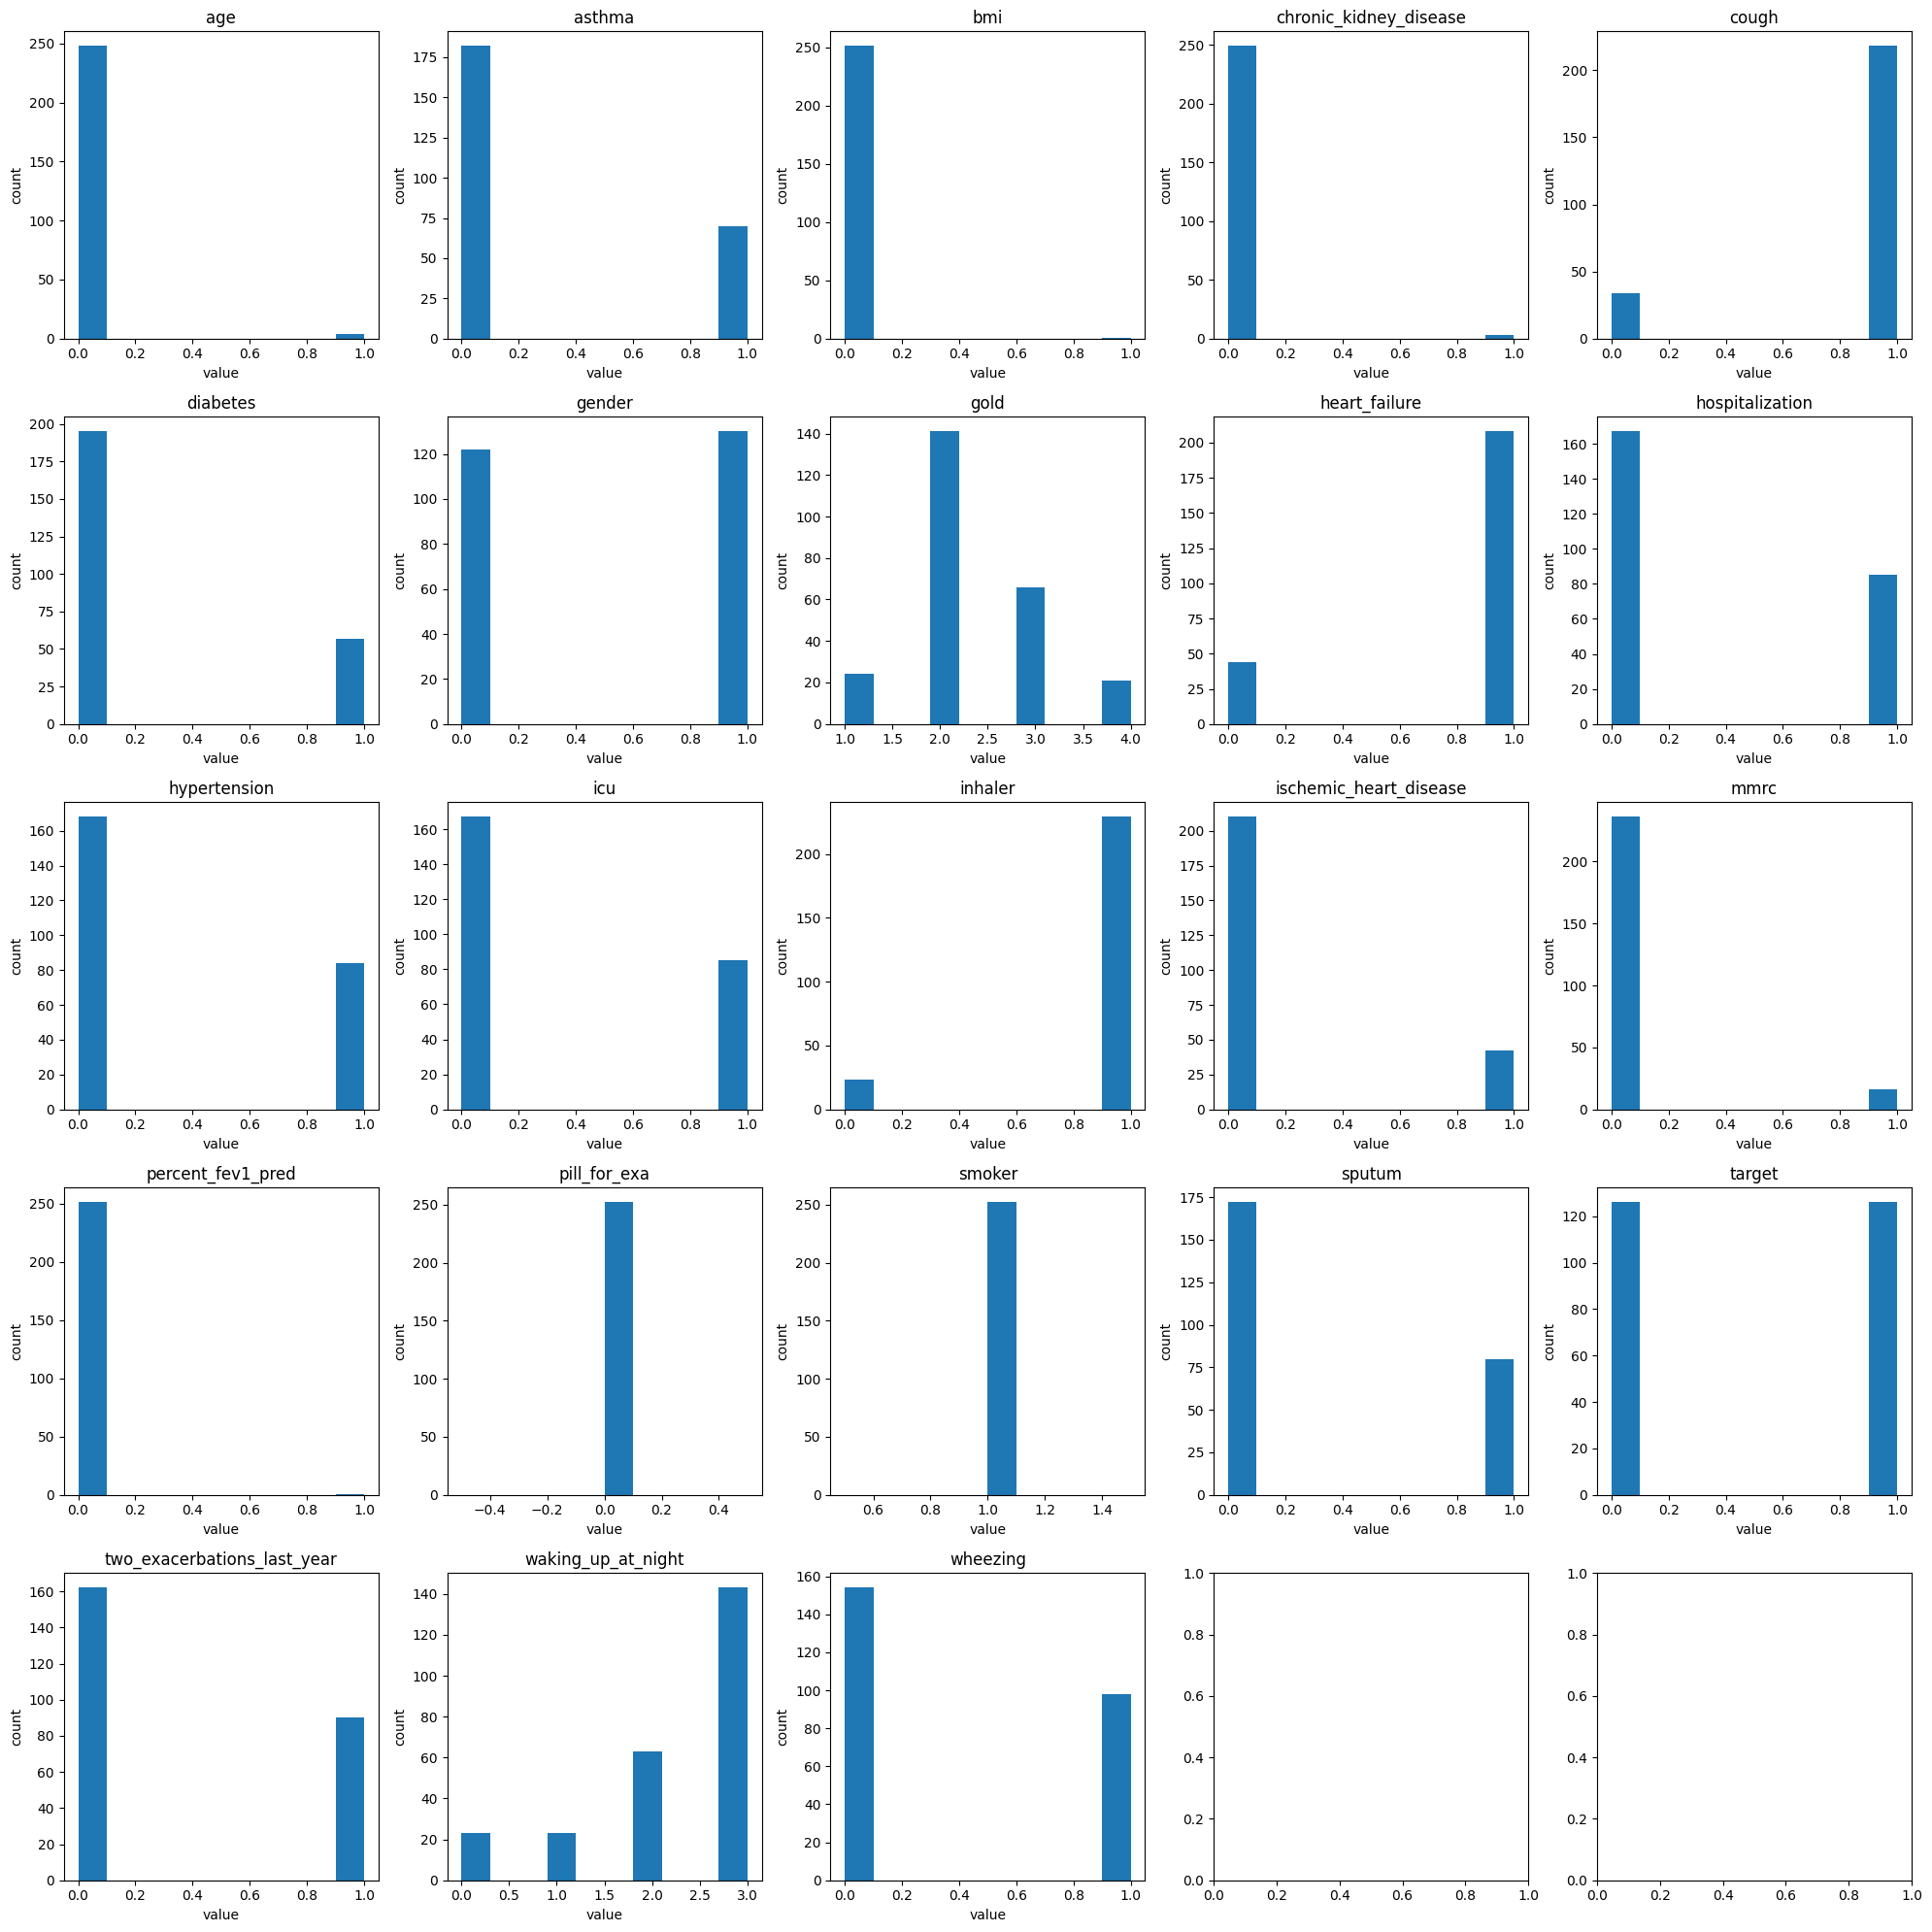

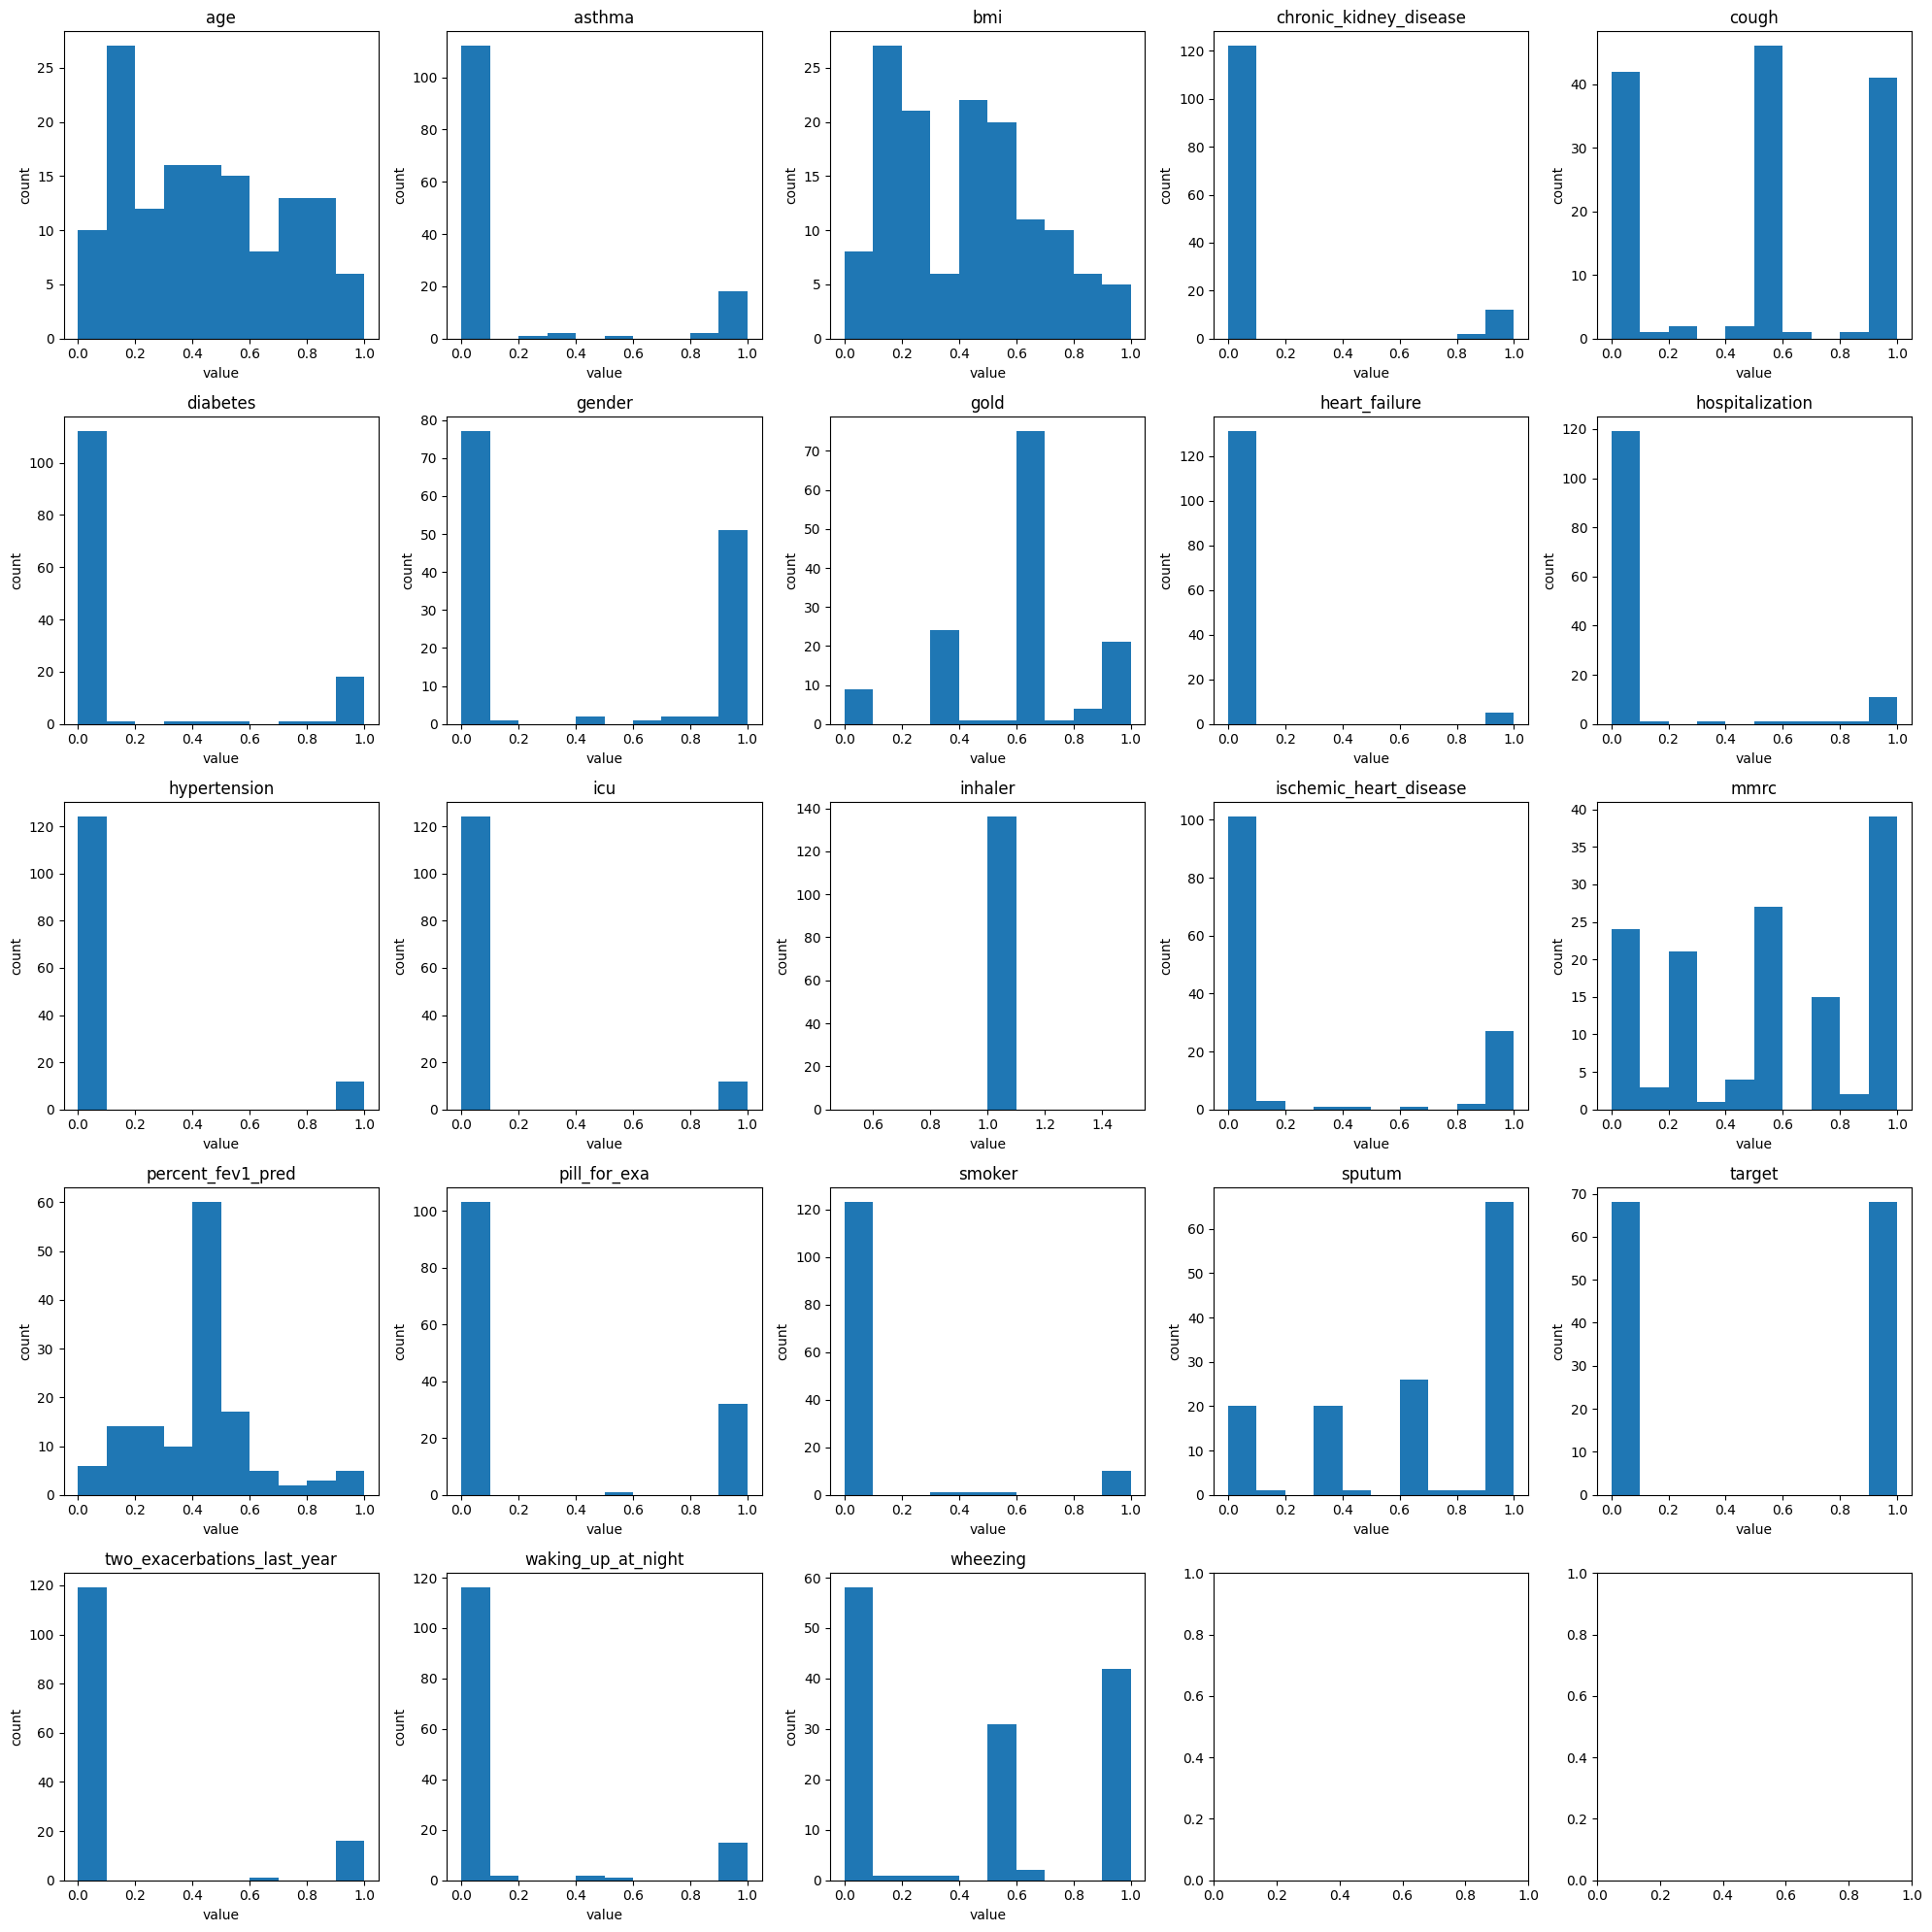

In [ ]:
# create a 5x5 figure
fig, ax = plt.subplots(5, 5, figsize=(20, 20))
fig.subtitle = "Histograms of the variables in the harvard dataset"
# plot histograms of all variables
for i, var in enumerate(harvard.columns):
    # print(i, var)
    ax = plt.subplot(5, 5, i + 1)
    ax.hist(harvard[var])
    ax.set_title(var)
    ax.set_xlabel('value')
    ax.set_ylabel('count')
plt.tight_layout()


fig, ax = plt.subplots(5, 5, figsize=(20, 20))
fig.subtitle = "Histograms of the variables in the triage dataset"
# plot histograms of all variables
for i, var in enumerate(triage.columns):
    # print(i, var)
    ax = plt.subplot(5, 5, i + 1)
    ax.hist(triage[var])
    ax.set_title(var)
    ax.set_xlabel('value')
    ax.set_ylabel('count')
plt.tight_layout()

plt.show()

# Feature Importance

### Lofo

c:\Users\Daniel\AppData\Local\Programs\Python\Python310\lib\site-packages\lofo\lofo_importance.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


  0%|          | 0/22 [00:00<?, ?it/s]

C:\Users\Daniel\AppData\Local\Temp\ipykernel_16116\3595741345.py:20: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  harvard_importance_df['importance_mean'] = harvard_importance_df.mean(axis=1)
C:\Users\Daniel\AppData\Local\Temp\ipykernel_16116\3595741345.py:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  harvard_importance_df['importance_std'] = harvard_importance_df.std(axis=1)


  0%|          | 0/22 [00:00<?, ?it/s]

                        feature  importance_mean  importance_std  val_imp_0  \
15                         mmrc         0.008472        0.033004   0.020833   
8                           bmi         0.006230        0.060287  -0.020833   
17                 hypertension         0.004167        0.020412   0.000000   
21                     wheezing         0.000754        0.090972  -0.020833   
20                heart_failure         0.000000        0.000000   0.000000   
5                       inhaler         0.000000        0.000000   0.000000   
12       chronic_kidney_disease         0.000000        0.000000   0.000000   
1   two_exacerbations_last_year        -0.002083        0.014583   0.000000   
3            waking_up_at_night        -0.003710        0.019814   0.000000   
16                          icu        -0.003869        0.016085   0.000000   
14              hospitalization        -0.008036        0.023587   0.000000   
2                        asthma        -0.008611    

C:\Users\Daniel\AppData\Local\Temp\ipykernel_16116\3595741345.py:67: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  triage_importance_df['importance_mean'] = triage_importance_df.mean(axis=1)
C:\Users\Daniel\AppData\Local\Temp\ipykernel_16116\3595741345.py:69: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  triage_importance_df['importance_std'] = triage_importance_df.std(axis=1)


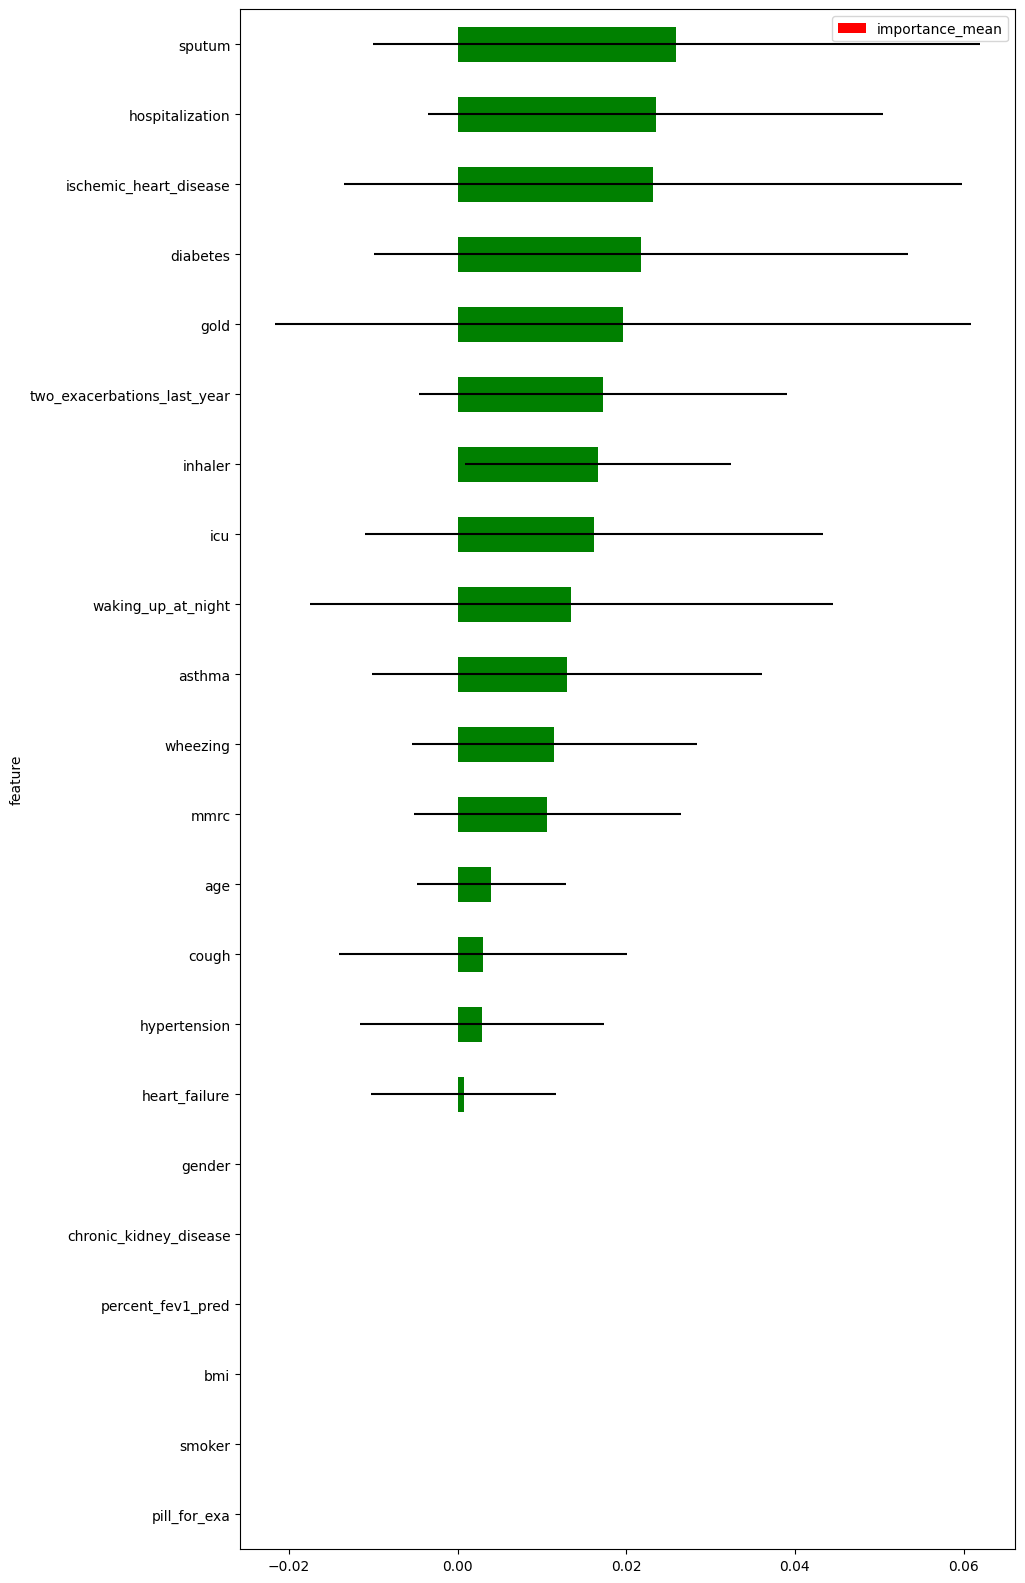

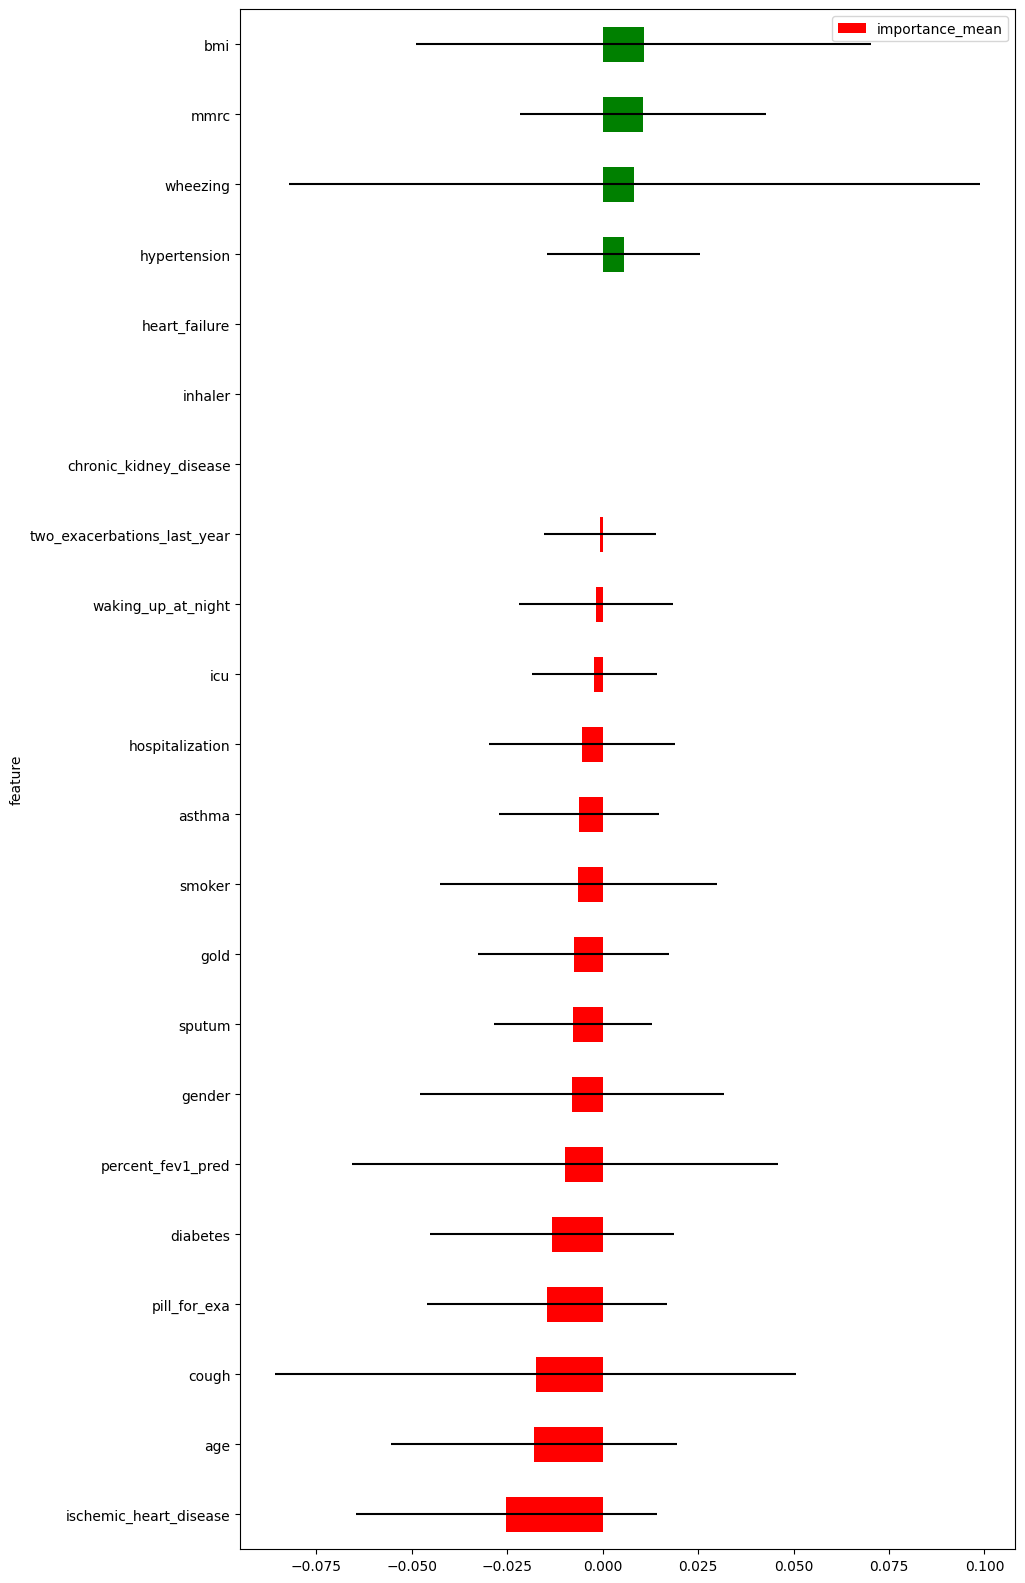

In [ ]:
# using lofo importance
from lofo import LOFOImportance, Dataset, plot_importance
from sklearn.model_selection import KFold

# define the validation scheme
harvard_cv = KFold(n_splits=10, shuffle=True, random_state=42) # Don't shuffle to keep the time split split validation

# define the binary target and the features
harvard_dataset = Dataset(df=harvard, target="target", features=[col for col in harvard.columns if col != "target"])

# define the validation scheme and scorer. The default model is LightGBM
harvard_lofo_imp = LOFOImportance(harvard_dataset, cv=harvard_cv, scoring="roc_auc")
print(harvard_lofo_imp)
# get the mean and standard deviation of the importances in pandas format
harvard_importance_df = harvard_lofo_imp.get_importance()
# print(harvard_importance_df)
# drop val_imp3 from triage_importance_df
harvard_importance_df= harvard_importance_df.drop(columns=['val_imp_3'])
# calculate importance_mean
harvard_importance_df['importance_mean'] = harvard_importance_df.mean(axis=1)
# calculate importance_std
harvard_importance_df['importance_std'] = harvard_importance_df.std(axis=1)
# plot the means and standard deviations of the importances
plot_importance(harvard_importance_df, figsize=(10, 20))

##### Exaggerate

# exaggerate_cv = KFold(n_splits=10, shuffle=True, random_state=42) # Don't shuffle to keep the time split split validation

# # define the binary target and the features
# exaggerate_dataset = Dataset(df=exaggerate, target="target", features=[col for col in exaggerate.columns if col != "target"])

# # define the validation scheme and scorer. The default model is LightGBM
# exaggerate_lofo_imp = LOFOImportance(exaggerate_dataset, cv=exaggerate_cv, scoring="roc_auc")

# # get the mean and standard deviation of the importances in pandas format
# exaggerate_importance_df = exaggerate_lofo_imp.get_importance()
# print(exaggerate_importance_df)

# # drop columns containing only NaNs
# exaggerate_importance_df = exaggerate_importance_df.dropna(axis=1, how="all")
# # calculate importance_mean
# exaggerate_importance_df['importance_mean'] = exaggerate_importance_df.mean(axis=1)
# # calculate importance_std
# exaggerate_importance_df['importance_std'] = exaggerate_importance_df.std(axis=1)

# # plot the means and standard deviations of the importances
# plot_importance(exaggerate_importance_df, figsize=(10, 20))

####### Traige

triage_cv = KFold(n_splits=10, shuffle=True, random_state=42) # Don't shuffle to keep the time split split validation

# define the binary target and the features
triage_dataset = Dataset(df=triage, target="target", features=[col for col in triage.columns if col != "target"])

# define the validation scheme and scorer. The default model is LightGBM
triage_lofo_imp = LOFOImportance(triage_dataset, cv=triage_cv, scoring="roc_auc")

# get the mean and standard deviation of the importances in pandas format
triage_importance_df = triage_lofo_imp.get_importance()
print(triage_importance_df)

# drop columns containin gonly nan
triage_importance_df = triage_importance_df.dropna(axis=1, how="all")
# calculate importance_mean
triage_importance_df['importance_mean'] = triage_importance_df.mean(axis=1)
# calculate importance_std
triage_importance_df['importance_std'] = triage_importance_df.std(axis=1)
# plot the means and standard deviations of the importances
plot_importance(triage_importance_df, figsize=(10, 20))


# export all 3 dataframes to excel
# with pd.ExcelWriter('feature_importances_lofo.xlsx') as writer:
#     exaggerate_importance_df.to_excel(writer, sheet_name='exaggerate')
#     harvard_importance_df.to_excel(writer, sheet_name='harvard')
#     triage_importance_df.to_excel(writer, sheet_name='triage')



### Drop columns

In [ ]:
from sklearn.base import clone



rf = RandomForestClassifier(
         n_estimators=100,
         n_jobs=-1,
         min_samples_leaf = 20,
         oob_score=True,
         random_state = 42)
rf.fit(X_train, y_train)

# drop columns importance
def dropcol_importances(rf, X_train, y_train):
    rf_ = clone(rf)
    # rf_.random_state = 42
    rf_.fit(X_train, y_train)
    
    #use out of bag error as performance measurement
    baseline = rf_.oob_score_
    imp = []
    for col in X_train.columns:
        X = X_train.drop(col, axis=1)
        rf_ = clone(rf)
        # rf_.random_state = 42
        rf_.fit(X, y_train)
        o = rf_.oob_score_
        imp.append(baseline - o)
    imp = np.array(imp)
    I = pd.DataFrame(
            data={'Feature':X_train.columns,
                  'Importance':imp})
    I = I.set_index('Feature')
    I = I.sort_values('Importance', ascending=True)
    return I

# create figure for all 3 datasets
fig, axs = plt.subplots(1, 3, figsize=(20, 10))
fig.suptitle('Drop column importance', fontsize=16)
X_train, X_test_harvard, y_train, y_test_harvard = train_test_split(harvard.drop(columns=['target']), harvard['target'], test_size=0.2)
harvard_imp = dropcol_importances(rf, X_train, y_train)
harvard_imp.plot(kind = 'barh', ax=axs[0], title="Harvard")

X_train, X_test_harvard, y_train, y_test_harvard = train_test_split(exaggerate.drop(columns=['target']), exaggerate['target'], test_size=0.2)
exaggerate_imp = dropcol_importances(rf, X_train, y_train)
exaggerate_imp.plot(kind = 'barh', ax=axs[1], title="Exaggerate")

X_train, X_test_harvard, y_train, y_test_harvard = train_test_split(triage.drop(columns=['target']), triage['target'], test_size=0.2)
triage_imp = dropcol_importances(rf, X_train, y_train)
triage_imp.plot(kind = 'barh', ax=axs[2], title="Triage")



['asthma', 'gold', 'heart_failure', 'icu', 'inhaler', 'ischemic_heart_disease', 'mmrc', 'sputum', 'two_exacerbations_last_year', 'waking_up_at_night']
['bmi', 'cough', 'diabetes', 'ischemic_heart_disease', 'waking_up_at_night', 'wheezing']
{'ischemic_heart_disease', 'waking_up_at_night'}


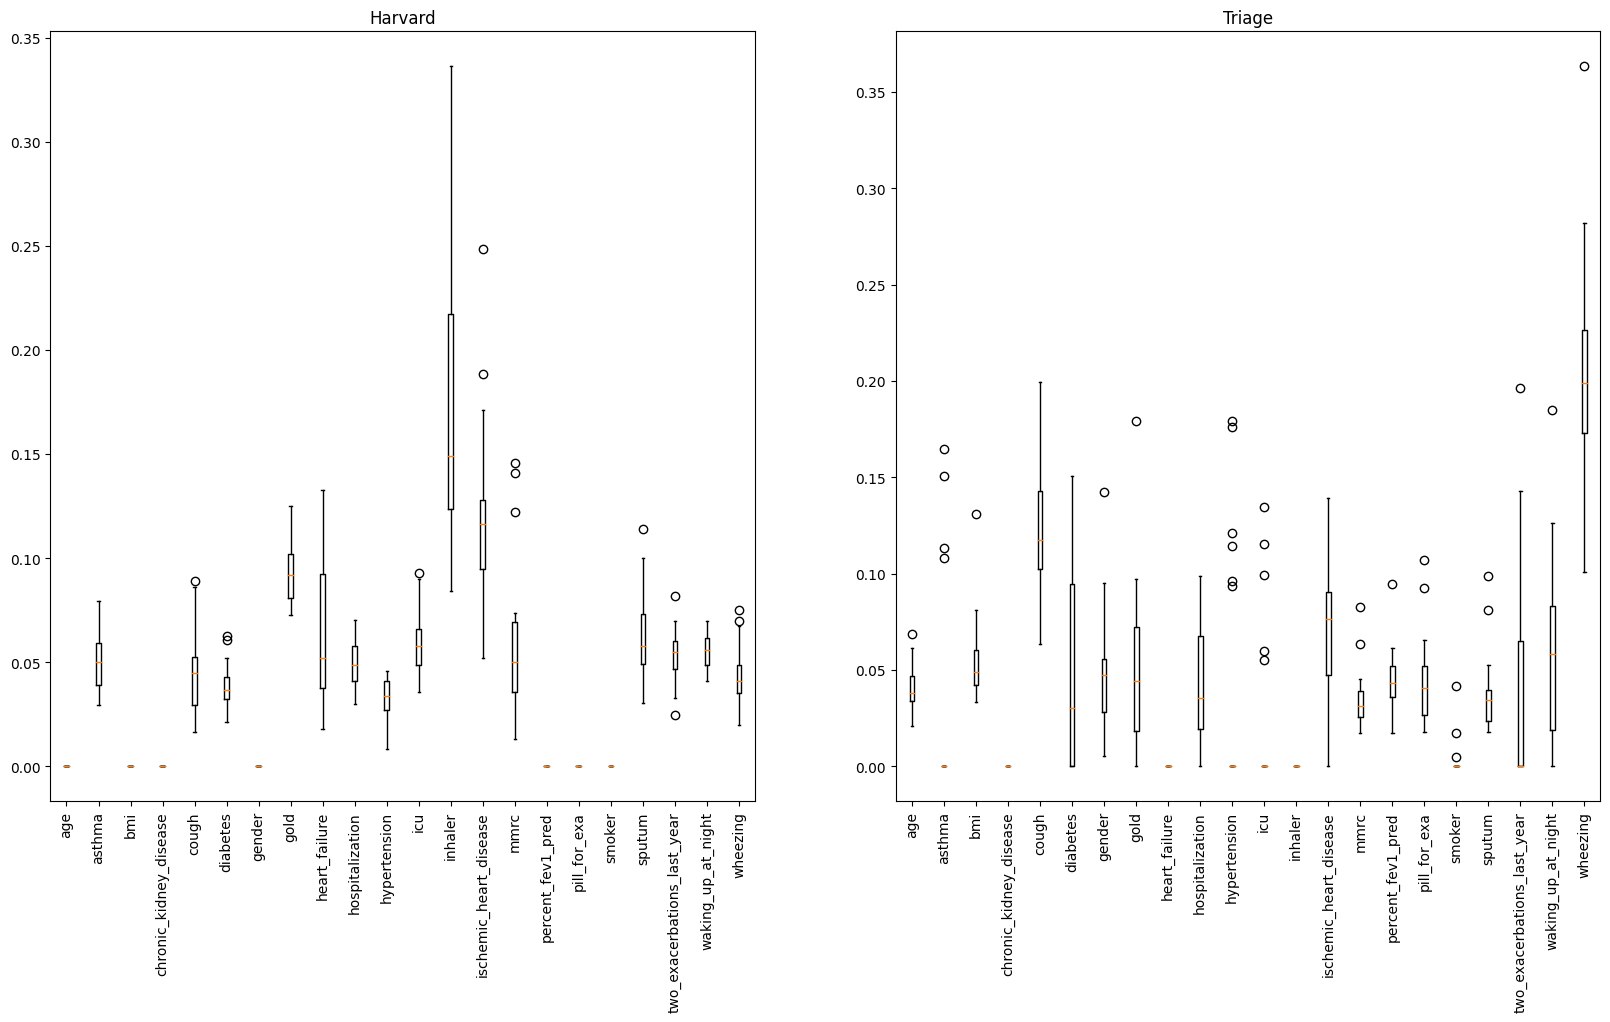

In [ ]:
# fit a random forest classifier
from sklearn.ensemble import RandomForestClassifier
# import Xgboost classifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

# create a figure with two plots
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

num_fits = 25
# fit a random forest classifier to the 'exaggerate' dataset

clf = XGBClassifier(random_state=42)

# get feature names as string list
features = list(harvard.drop(columns=['target']).columns)

harvard_feature_importances = {}
for i in range(len(features)):
    harvard_feature_importances[features[i]] = []
# fit a random forest classifier to the 'harvard' dataset
for i in range(num_fits):
    X_train, X_test_harvard, y_train, y_test_harvard = train_test_split(harvard.drop(columns=['target']), harvard['target'], test_size=0.2)
    clf.fit(X_train, y_train)
    
    # add feature importances to dictionary
    for feature, importance in zip(features, clf.feature_importances_):
        if feature in harvard_feature_importances.keys():
            harvard_feature_importances[feature].append(importance)
        else:
            harvard_feature_importances[feature] = [importance]

triage_feature_importances = {}
for i in range(len(features)):
    triage_feature_importances[features[i]] = []
# fit a random forest classifier to the 'exaggerate' dataset
for i in range(num_fits):
    X_train, X_test_harvard, y_train, y_test_harvard = train_test_split(triage.drop(columns=['target']), triage['target'], test_size=0.2)
    clf.fit(X_train, y_train)

    # add feature importances to dictionary
    for feature, importance in zip(features, clf.feature_importances_):
        if feature in triage_feature_importances.keys():
            triage_feature_importances[feature].append(importance)
        else:
            triage_feature_importances[feature] = [importance]

# plot a boxplot for each feature for each dataset in one figure
for feature, importance in harvard_feature_importances.items():
    axs[0].boxplot(importance, positions=[features.index(feature)])
axs[0].set_xticklabels(features, rotation=90)
axs[0].set_title('Harvard')

for feature, importance in triage_feature_importances.items():
    axs[1].boxplot(importance, positions=[features.index(feature)])
axs[1].set_xticklabels(features, rotation=90)
axs[1].set_title('Triage')

# get the variables where the mean in both datasets is above 0.05
harvard_features = []
triage_features = []
for feature, importance in harvard_feature_importances.items():
    if np.mean(importance) > 0.05:
        harvard_features.append(feature)
for feature, importance in triage_feature_importances.items():
    if np.mean(importance) > 0.05:
        triage_features.append(feature)

print(harvard_features)
print(triage_features)

# print the intersection
print(set(harvard_features).intersection(set(triage_features)))

# Intra Dataset Classification

Accuracy: 0.7857142857142857
['wheezing', 'bmi', 'cough', 'age', 'sputum', 'percent_fev1_pred', 'mmrc', 'gold', 'pill_for_exa', 'diabetes', 'waking_up_at_night', 'two_exacerbations_last_year', 'ischemic_heart_disease', 'gender', 'hospitalization', 'hypertension', 'icu', 'smoker', 'heart_failure', 'chronic_kidney_disease', 'asthma', 'inhaler']
Accuracy: 0.75


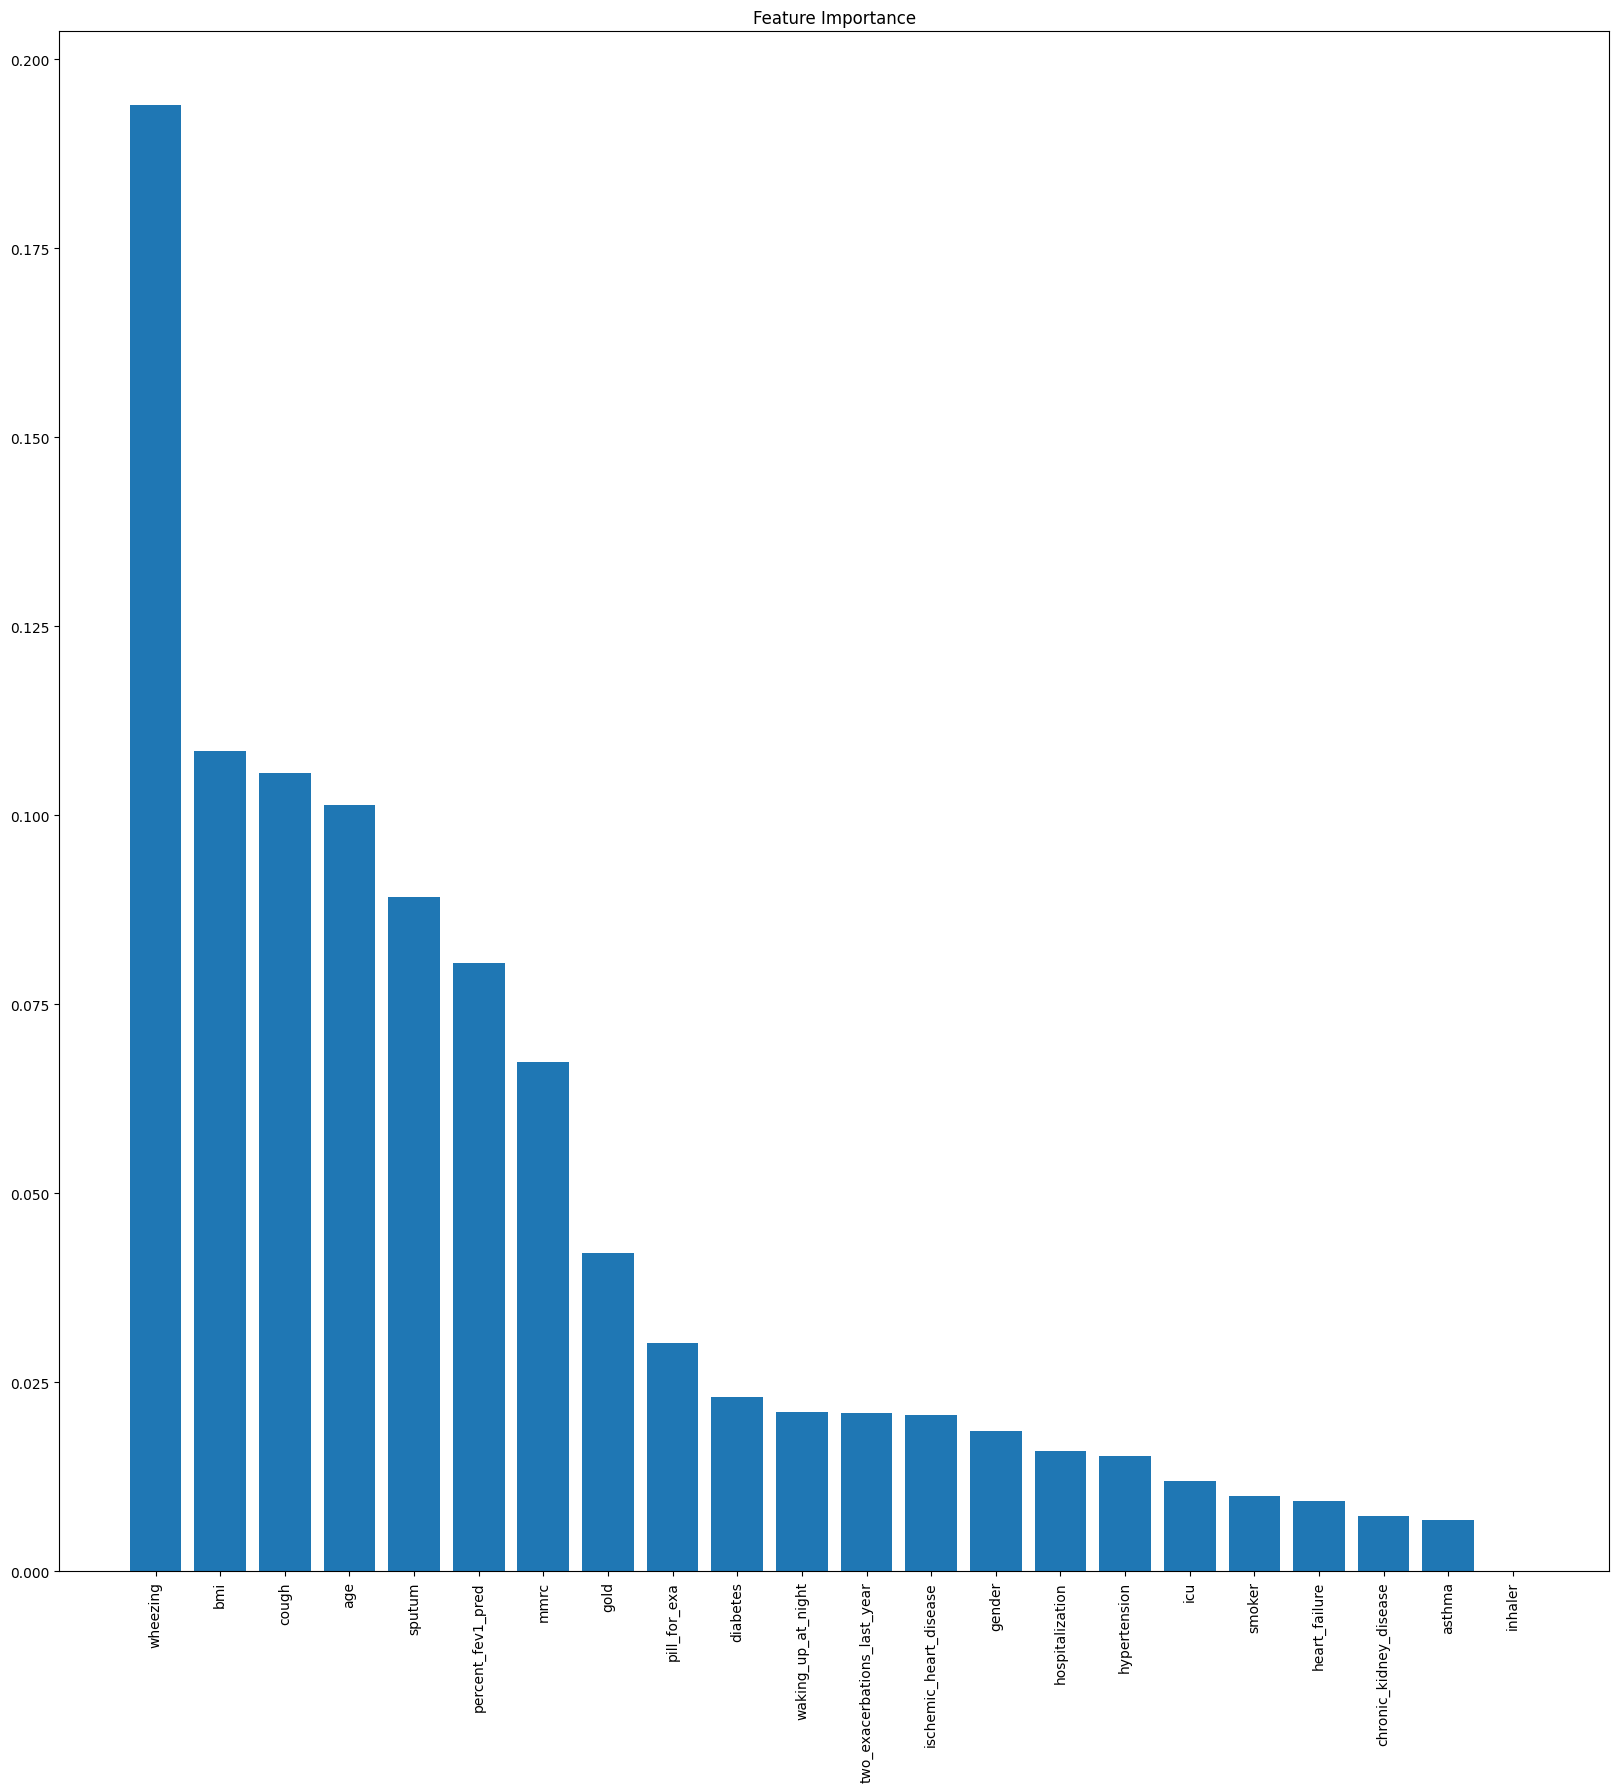

In [ ]:
target = "target"

X = triage.drop(columns=[target], axis=1)
y = triage[target]

# split into train and test set
X_train, X_test_harvard, y_train, y_test_harvard = train_test_split(X, y, test_size=0.2)
# clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
# models, predictions = clf.fit(X_train, X_test, y_train, y_test)
# models

from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred_harvard = clf.predict(X_test_harvard)
print("Accuracy:", metrics.accuracy_score(y_test_harvard, y_pred_harvard))

# get variable importances
importances = clf.feature_importances_
# sort in descending order
indices = np.argsort(importances)[::-1]
# # rearrange feature names so they match the sorted feature importances
names = [X.columns[i] for i in indices]

print(names)

# get the variables with the highest importance
selection = names[:10]

# train KNN with the selected variables
clf = XGBClassifier()
clf.fit(X_train[selection], y_train)
y_pred_harvard = clf.predict(X_test_harvard[selection])
print("Accuracy:", metrics.accuracy_score(y_test_harvard, y_pred_harvard))

# create plot
fig = plt.figure(figsize=(20,20))
plt.title("Feature Importance")
# add bars
plt.bar(range(X.shape[1]), importances[indices])
# add feature names as x-axis labels
plt.xticks(range(X.shape[1]), names, rotation=90)
# show plot
plt.show()

Accuracy: 0.8431372549019608
['gold', 'waking_up_at_night', 'sputum', 'asthma', 'hospitalization', 'hypertension', 'wheezing', 'diabetes', 'two_exacerbations_last_year', 'icu', 'ischemic_heart_disease', 'heart_failure', 'inhaler', 'cough', 'mmrc', 'age', 'chronic_kidney_disease', 'percent_fev1_pred', 'bmi', 'pill_for_exa', 'smoker', 'gender']
Accuracy: 0.8235294117647058


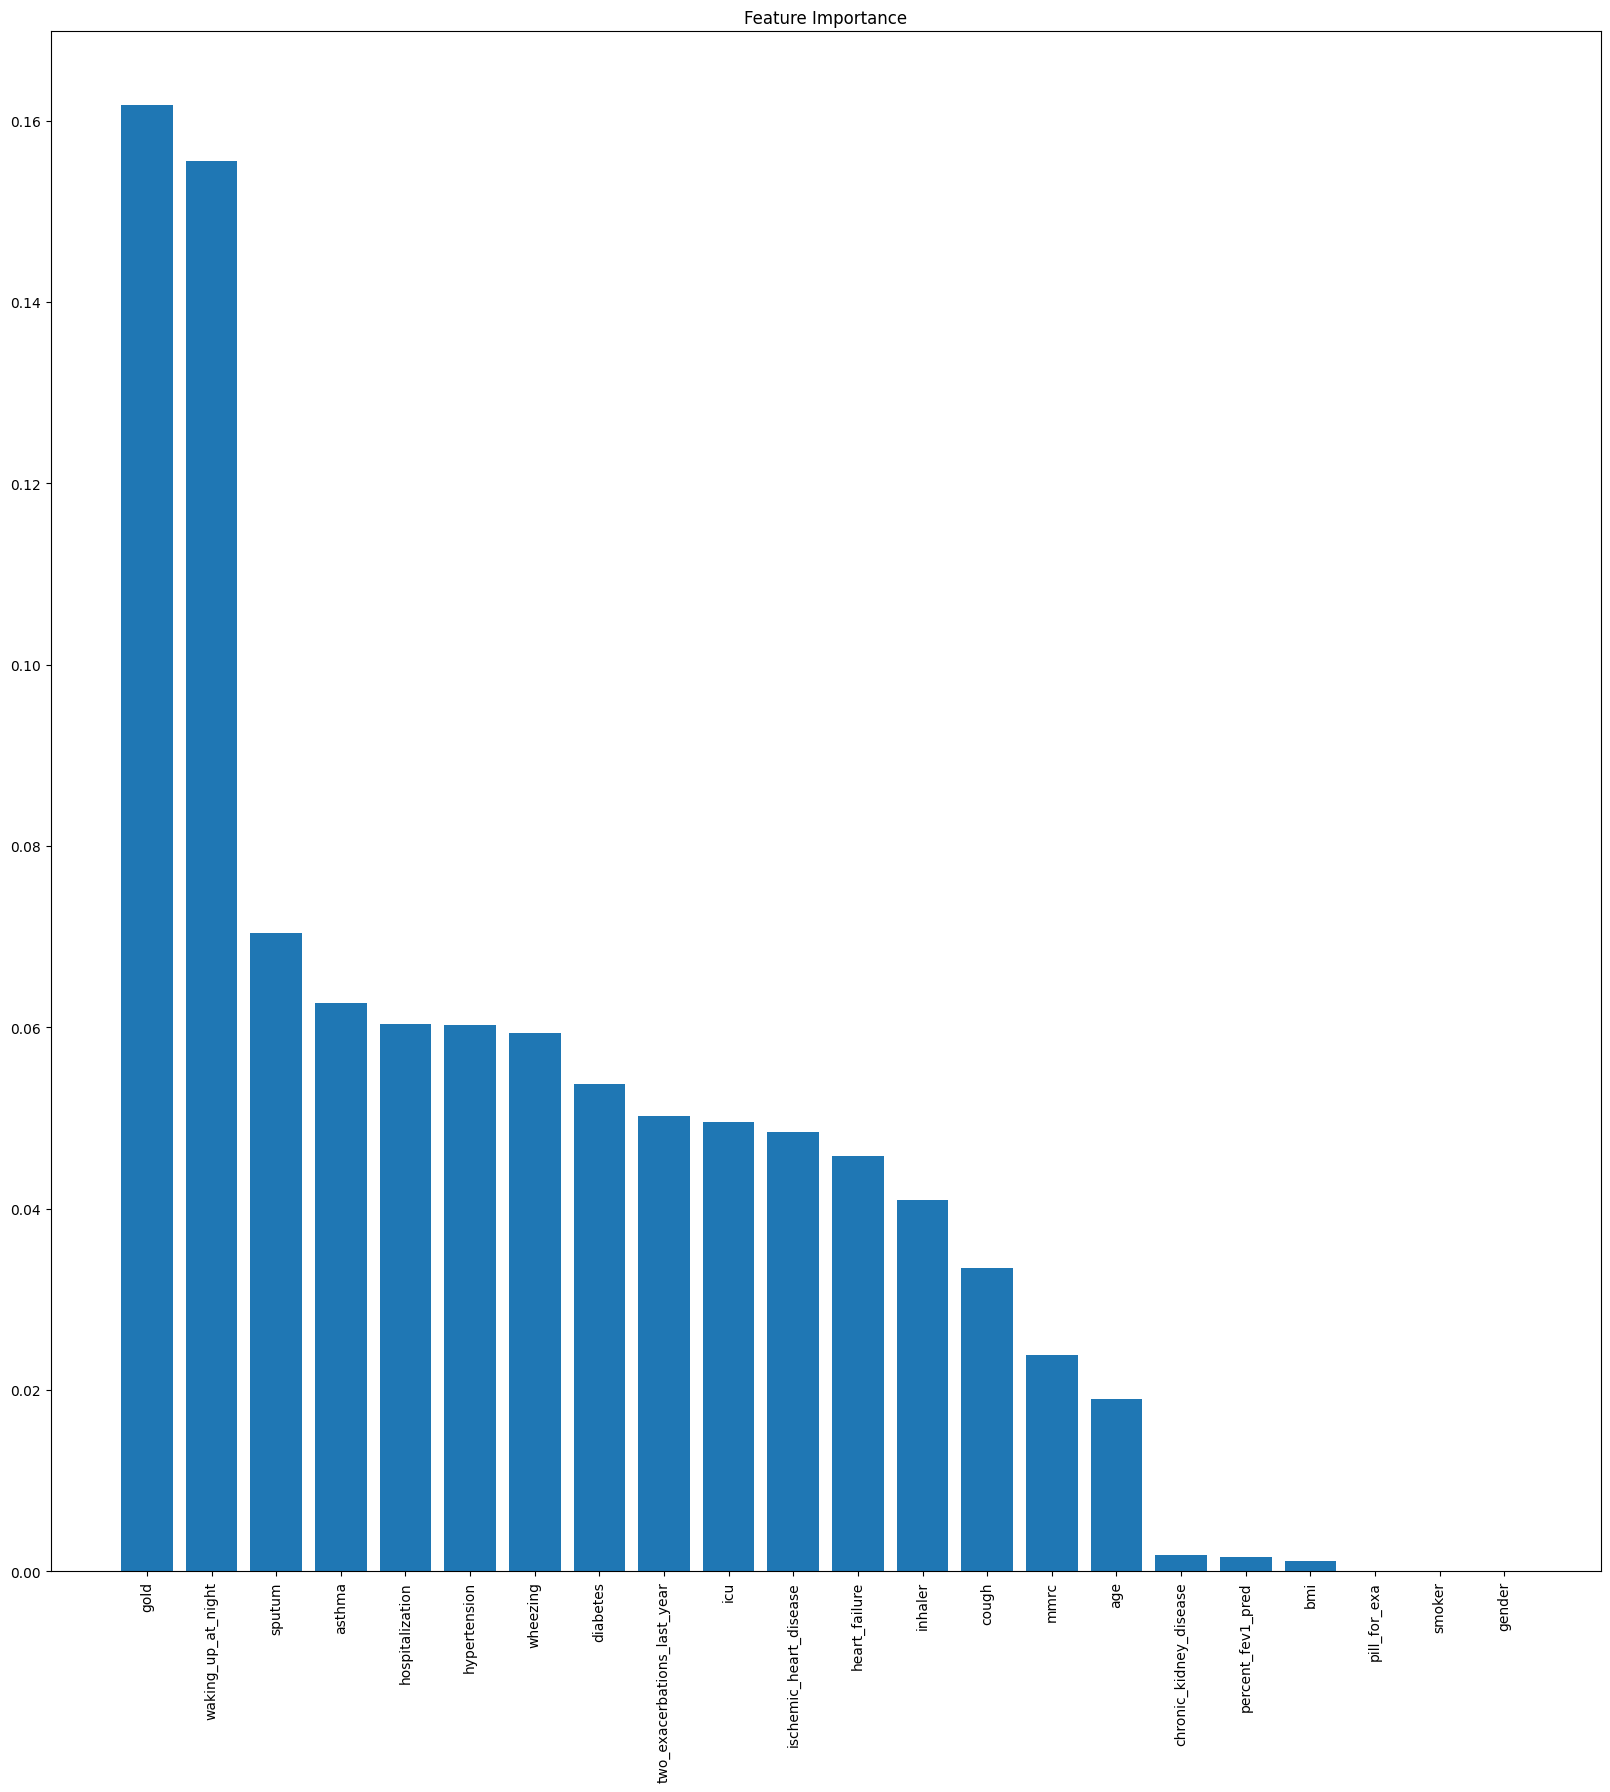

{'diabetes', 'waking_up_at_night', 'wheezing'}


In [ ]:
# harvard

target = "target"

X = harvard.drop(columns=[target], axis=1)
y = harvard[target]

# split into train and test set
X_train, X_test_harvard, y_train, y_test_harvard = train_test_split(X, y, test_size=0.2)
# clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
# models, predictions = clf.fit(X_train, X_test, y_train, y_test)
# models

from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred_harvard = clf.predict(X_test_harvard)
print("Accuracy:", metrics.accuracy_score(y_test_harvard, y_pred_harvard))

# get variable importances
importances = clf.feature_importances_
# sort in descending order
indices = np.argsort(importances)[::-1]
# # rearrange feature names so they match the sorted feature importances
names = [X.columns[i] for i in indices]
print(names)


# get the variables with the highest importance
selection = names[:10]

# train KNN with the selected variables
clf = XGBClassifier()
clf.fit(X_train[selection], y_train)
y_pred_harvard = clf.predict(X_test_harvard[selection])
print("Accuracy:", metrics.accuracy_score(y_test_harvard, y_pred_harvard))

# create plot
fig = plt.figure(figsize=(20,20))
plt.title("Feature Importance")
# add bars
plt.bar(range(X.shape[1]), importances[indices])
# add feature names as x-axis labels
plt.xticks(range(X.shape[1]), names, rotation=90)
# show plot
plt.show()

# print features that are in the top 10 for both datasets
print(set(names[:10]).intersection(set(triage_features[:10])))

# Inter Dataset Classification

(252, 23)
(136, 23)


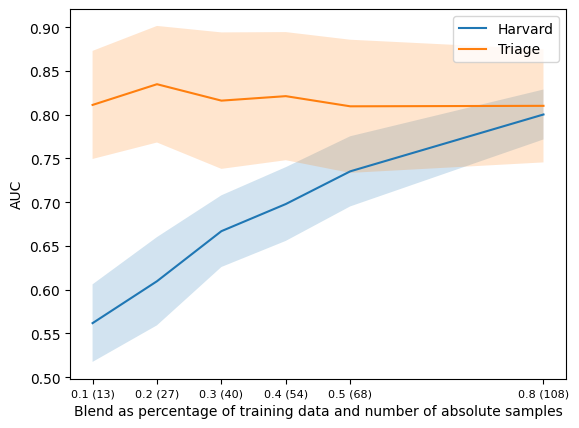

In [ ]:
from sklearn import metrics
# triage => harvard
print(harvard.shape)
print(triage.shape)


# TODO try different blend percentages and see how it affects the accuracy and AUC
relevant_vars = harvard.columns #['diabetes', 'waking_up_at_night', 'wheezing','gold', 'target']
aucs_harvard_fold = []
aucs_triage_fold = []
for i in range(50):
    blend_percentages = [0.1, 0.2, 0.3, 0.4, 0.5, 0.8]
    blend_absolute = []
    aucs_harvard = []
    aucs_triage = []
    for blend_percentage in blend_percentages:
        num_to_add = blend_percentage * len(triage)
        blend_absolute.append(num_to_add)
        percentage_harvard = num_to_add / len(harvard)

        # split harvard into blending and test set
        blending_harvard, testing_harvard = train_test_split(harvard, test_size=1-percentage_harvard)
        training_triage, testing_triage = train_test_split(triage, test_size=0.2)
        # drop columns not in relevant vars
        blending_harvard = blending_harvard[relevant_vars]
        testing_harvard = testing_harvard[relevant_vars]
        triage_training_selection = training_triage[relevant_vars]
        triage_testing_selection = testing_triage[relevant_vars]

        blended = pd.concat([triage_training_selection, blending_harvard])

        # train on triage dataset
        X_train = blended.drop(columns=['target'], axis=1)
        # print Na values in X_train

        # X_train = X_train[relevant_vars]
        y_train = blended['target']

        X_test_harvard = testing_harvard.drop(columns=['target'], axis=1)
        # X_test = X_test[relevant_vars]
        y_test_harvard = testing_harvard['target']

        X_test_triage = triage_testing_selection.drop(columns=['target'], axis=1)
        y_test_triage = triage_testing_selection['target']

        clf = RandomForestClassifier()
        clf.fit(X_train, y_train)
        y_pred_harvard = clf.predict(X_test_harvard)
        
        y_pred_triage = clf.predict(X_test_triage)
        # calculate AUC for harvard
        fpr, tpr, thresholds = metrics.roc_curve(y_test_harvard, y_pred_harvard)
        auc = metrics.auc(fpr, tpr)
        aucs_harvard.append(auc)
        # calculate accuracy for harvard
        # print("Accuracy:", metrics.accuracy_score(y_test_harvard, y_pred_harvard))


        # calculate AUC for triage
        fpr, tpr, thresholds = metrics.roc_curve(y_test_triage, y_pred_triage)
        auc = metrics.auc(fpr, tpr)
        aucs_triage.append(auc)
    aucs_harvard_fold.append(aucs_harvard)
    aucs_triage_fold.append(aucs_triage)

# get the mean AUC for each blend percentage
aucs_harvard_mean = np.mean(aucs_harvard_fold, axis=0)
aucs_triage_mean = np.mean(aucs_triage_fold, axis=0)
aucs_harvard_std = np.std(aucs_harvard_fold, axis=0)
aucs_triage_std = np.std(aucs_triage_fold, axis=0)

# plot mean and fill between upper and lower bound
plt.plot(blend_percentages, aucs_harvard_mean, label="Harvard")
plt.fill_between(blend_percentages, aucs_harvard_mean - aucs_harvard_std, aucs_harvard_mean + aucs_harvard_std, alpha=0.2)
plt.plot(blend_percentages, aucs_triage_mean, label="Triage")
plt.fill_between(blend_percentages, aucs_triage_mean - aucs_triage_std, aucs_triage_mean + aucs_triage_std, alpha=0.2)


# plt.plot(blend_percentages, aucs_harvard, label="Harvard")
# plt.plot(blend_percentages, aucs_triage, label="Triage")
# set x-axis ticks
plt.xticks(blend_percentages, [str(blend_percentages[i]) + " (" + str(int(blend_absolute[i])) + ")" for i in range(len(blend_percentages))])
# make x ticks smaller
plt.xticks(fontsize=8)
plt.xlabel("Blend as percentage of training data and number of absolute samples")
plt.ylabel("AUC")
plt.legend()
plt.show()

In [ ]:
# harvard => triage

# triage => harvard


relevant_vars = harvard.columns #['diabetes', 'waking_up_at_night', 'wheezing','gold', 'target']

num_to_add = 0.1 * len(harvard)
percentage_triage = num_to_add / len(triage)
print(percentage_triage)

# split harvard into blending and test set
blending_harvard, testing_harvard = train_test_split(triage, test_size=1-percentage_triage)

# drop columns not in relevant vars
blending_harvard = blending_harvard[relevant_vars]
testing_harvard = testing_harvard[relevant_vars]
harvard_selection = harvard[relevant_vars]

print(blending_harvard.columns)

blended = pd.concat([harvard_selection, blending_harvard])

# train on triage dataset
X_train = blended.drop(columns=['target'], axis=1)
# print Na values in X_train

# X_train = X_train[relevant_vars]
y_train = blended['target']

X_test_harvard = testing_harvard.drop(columns=['target'], axis=1)
# X_test = X_test[relevant_vars]
y_test_harvard = testing_harvard['target']

clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred_harvard = clf.predict(X_test_harvard)
print("Accuracy:", metrics.accuracy_score(y_test_harvard, y_pred_harvard))

Index(['age', 'asthma', 'bmi', 'chronic_kidney_disease', 'cough', 'diabetes',
       'gender', 'gold', 'heart_failure', 'hospitalization', 'hypertension',
       'icu', 'inhaler', 'ischemic_heart_disease', 'mmrc', 'percent_fev1_pred',
       'pill_for_exa', 'smoker', 'sputum', 'target',
       'two_exacerbations_last_year', 'waking_up_at_night', 'wheezing'],
      dtype='object')


NameError: name 'metrics' is not defined

### Neural Network

Index(['age', 'asthma', 'bmi', 'chronic_kidney_disease', 'cough', 'diabetes',
       'gender', 'gold', 'heart_failure', 'hospitalization', 'hypertension',
       'icu', 'inhaler', 'ischemic_heart_disease', 'mmrc', 'percent_fev1_pred',
       'pill_for_exa', 'smoker', 'sputum', 'target',
       'two_exacerbations_last_year', 'waking_up_at_night', 'wheezing'],
      dtype='object')


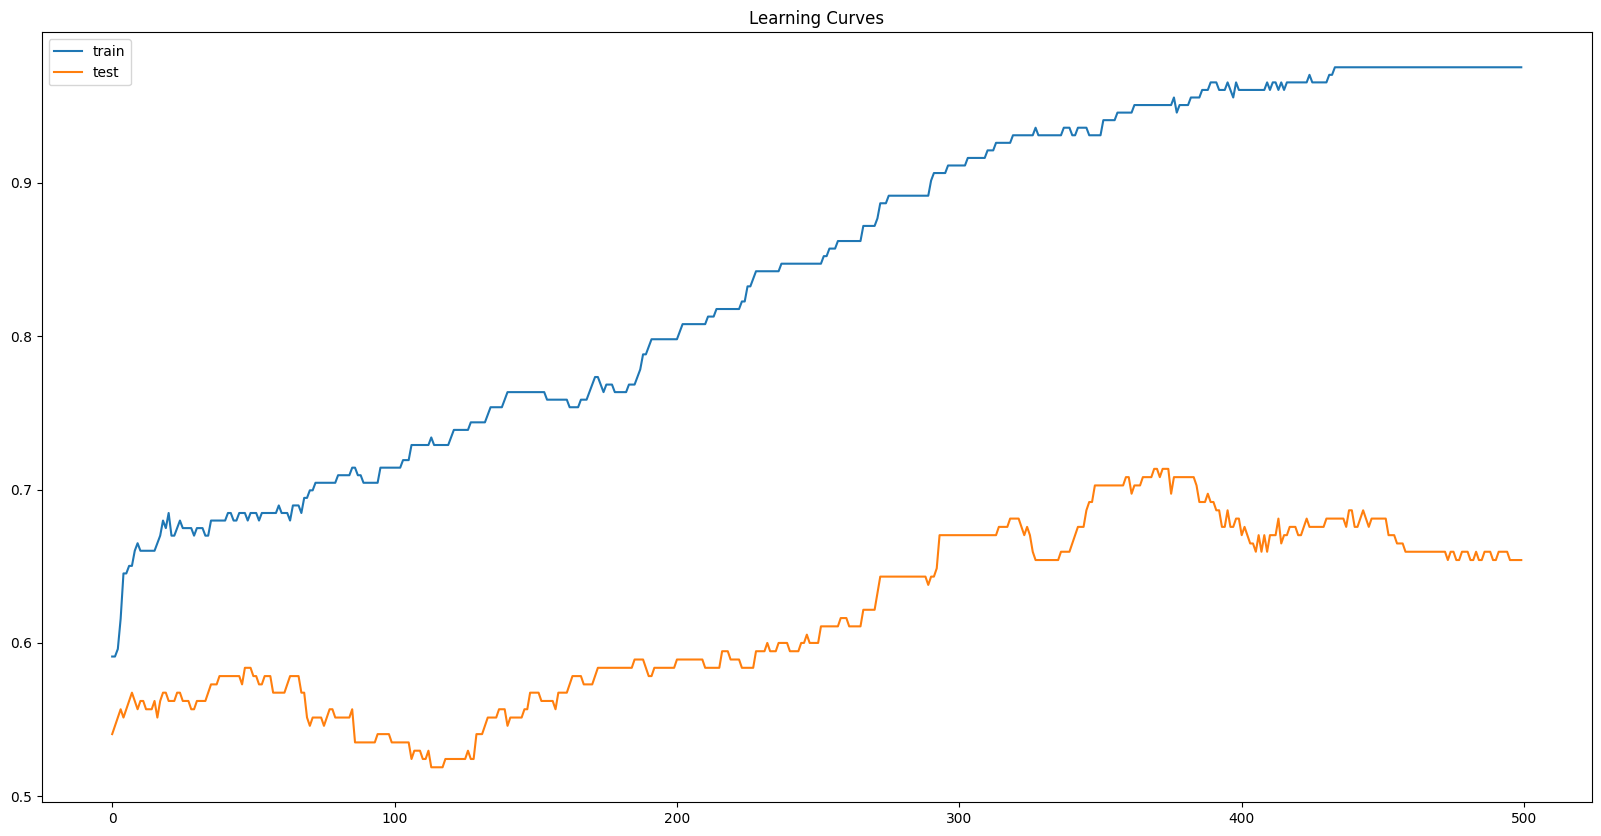

In [ ]:
relevant_vars = harvard.columns #['diabetes', 'waking_up_at_night', 'wheezing','gold', 'target']

num_to_add = 0.5 * len(triage)
percentage_harvard = num_to_add / len(harvard)

# split harvard into blending and test set
blending_harvard, testing_harvard = train_test_split(harvard, test_size=1-percentage_harvard)

# drop columns not in relevant vars
blending_harvard = blending_harvard[relevant_vars]
testing_harvard = testing_harvard[relevant_vars]
triage_training_selection = triage[relevant_vars]

print(blending_harvard.columns)

blended = pd.concat([triage_training_selection, blending_harvard])

# train on triage dataset
X_train = blended.drop(columns=['target'], axis=1)
# print Na values in X_train

# X_train = X_train[relevant_vars]
y_train = blended['target']

X_test_harvard = testing_harvard.drop(columns=['target'], axis=1)
# X_test = X_test[relevant_vars]
y_test_harvard = testing_harvard['target']

# create a keras model with 22 input features and a binary output
model = keras.Sequential()
model.add(keras.layers.Dense(12, input_dim=22, activation='relu'))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

# compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', ''])

history = model.fit(X_train, y_train, 
          epochs=500, 
          batch_size=1000, 
          validation_data=(X_test_harvard, y_test_harvard),
          verbose=0)

# plot the learning curves
fig = plt.figure(figsize=(20,10))
plt.title("Learning Curves")
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()